In [1]:
from settings import *
from utils import SpatialTransform, load_data, CoordsImageTest
from inrmorph import InrMorph
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
def set_wandb_logger():
    try:
        with open('logger_name.txt', 'r') as f:
            lines = f.readlines()
            if lines:
                logger_name = lines[-1].strip()
            else:
                logger_name = None
    except FileNotFoundError:
        print("The file 'logger_name.txt' does not exist.")
        logger_name = None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        logger_name = None
        
    run = wandb.init(
        project="INRMorph",
        name="visualizations_"+logger_name
        )
    return run, logger_name


def jacobian_determinant(coords, deformation_field):
    jac = compute_jacobian_matrix(coords, deformation_field)
    return torch.det(jac)


def compute_jacobian_matrix(coords, deformation_field):

    dim = coords.shape[1]
    # print("in jac", coords.shape, deformation_field.shape, dim)
    jacobian_matrix = torch.zeros(coords.shape[0], dim, dim)

    for i in range(dim):

        jacobian_matrix[:, i, :] = gradient(coords, deformation_field[:, i])
        # print("jacobian matrix", jacobian_matrix.shape)
    return jacobian_matrix   
    
         

    
def gradient(coords, output, grad_outputs=None):
    # print("in grad", coords.shape, output.shape)

    grad_outputs = torch.ones_like(output)
 
    grad = torch.autograd.grad(output, [coords], grad_outputs=grad_outputs, create_graph=True)[0]

    return grad  


def jacobain_determinant_numerical_approx(deformation_field):
    dx, dy, dz = torch.gradient(deformation_field, dim=(0, 1, 2))  # Gradients w.r.t x, y, z

    #each dx, dy, dz is of shape (260, 260, 250, 3), where the last dimension gives (∂x/∂x, ∂x/∂y, ∂x/∂z) and so on
    #we form the Jacobian matrix for each voxel
    jacobian_matrix = torch.stack([dx, dy, dz], dim=-1)  #shape: (260, 260, 250, 3, 3)

    #compute the determinant of the Jacobian matrix at each voxel
    jacobian_determinant = torch.det(jacobian_matrix) 

    return jacobian_determinant

In [3]:
transform = SpatialTransform()
validation_batch_size = 1
spatial_reg = 0
temporal_reg = 0
monotonicity_reg = 1
patch_size = [32, 32, 32]
batch_size = 338000
# batch_size = 13520000
project_name = "inrmorph"

#data loader
datapath = "data/AD/005_S_0814/resampled/"
data = sorted(glob.glob(datapath + "I*.nii"))
datamask = sorted(glob.glob(datapath + "/masks/I*.nii.gz"))

images = [load_data(img, True) for img in data]
masks = [load_data(mask, False) for mask in datamask]
I0 = images[0]
It = images
I0_mask = masks[0]
image_vector = CoordsImageTest(I0.shape, scale_factor = 1) #defining some fixed coordinates for the image
test_generator = DataLoader(dataset = image_vector, batch_size=batch_size, shuffle = False)


#time
observed_time_points = [0, 13, 14, 24]
# time = [0, 13, 14, 24]
time = [0, 1, 2, 7, 8.5, 10, 12, 13, 14,15.5, 16, 18, 20, 22, 24, 26.5]
time = torch.tensor(time, device=device, dtype=torch.float32)
normalized_time_points = time/12
# time_expand = time.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, *I0.shape)



os.environ["WANDB_NOTEBOOK_NAME"] = "inrmorph"
#load model and artifact
run, logger_name = set_wandb_logger()
print("Testing for run with model name: ", logger_name)
model = InrMorph(I0, I0, patch_size, spatial_reg, temporal_reg, monotonicity_reg, 4, "siren", "NCC", "analytic_gradient", "L2", normalized_time_points).to(device)
artifact = run.use_artifact(f'aishalawal/inrmorph/{logger_name}:best', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + "/model.ckpt")["state_dict"])
model.eval()
print(model)

print("Number of parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Model successfully loaded")

/its/home/as2614/.cache/pypoetry/virtualenvs/lowhighfieldreg-JaCS1Bme-py3.10/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
wandb: Currently logged in as: aishalawal. Use `wandb login --relogin` to force relogin


Testing for run with model name:  default_monotonicloss_0.5


wandb:   1 of 1 files downloaded.  


InrMorph(
  (t_mapping): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=10, out_features=64, bias=True)
  )
  (mapping): Siren(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): Linear(in_features=320, out_features=320, bias=True)
      (2): Linear(in_features=384, out_features=384, bias=True)
      (3): Linear(in_features=448, out_features=448, bias=True)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): Linear(in_features=576, out_features=3, bias=True)
    )
  )
)
Number of parameters 717847
Model successfully loaded


/tmp/ipykernel_3483282/799831581.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(artifact_dir + "/model.ckpt")["state_dict"])


In [4]:
stack_total_deformation_field = []
stack_total_jac_det = []
stack_tdf = []
stack_moved_images = []
for idx, t in enumerate(time):
    tm = normalized_time_points[idx]
    for k, coords in enumerate(test_generator):
        coords = coords.squeeze().to(device, dtype=torch.float32).requires_grad_(True)
        displacement_vector = model.test_step(coords, tm).squeeze().to(device)
        deformation_field = torch.add(displacement_vector, coords)

        jac_det = jacobian_determinant(coords, deformation_field) #shape is batch_size

        coords = coords.cpu().detach()
        deformation_field = deformation_field.cpu().detach()
        jac_det = jac_det.cpu().detach()
        
        if k==0:

            total_jac_det = jac_det
            total_deformation_field = deformation_field
        else:
            total_jac_det = torch.cat((total_jac_det, jac_det))
            total_deformation_field = torch.cat((total_deformation_field, deformation_field), 0)

    total_deformation_field = total_deformation_field.view(-1, 3).unsqueeze(0)
    stack_total_deformation_field.append(total_deformation_field)



    # moving followup images to baseline space
    if t in observed_time_points:
        id = observed_time_points.index(t)
        moved = transform.trilinear_interpolation(total_deformation_field.to(device), It[id].to(device)).view(It[id].shape)  
        stack_moved_images.append(moved.cpu().numpy().squeeze())

    stack_total_jac_det.append(total_jac_det.view(I0.shape))
    stack_tdf.append(total_deformation_field.view(*I0.shape,3))
    print(f"Time step {t} done")


# convert to numpy for plotting
I0 = I0.cpu().numpy()
I0_mask = I0_mask.cpu().numpy()
It = [img.cpu().numpy() for img in It]

Time step 0.0 done
Time step 1.0 done
Time step 2.0 done
Time step 7.0 done
Time step 8.5 done
Time step 10.0 done
Time step 12.0 done
Time step 13.0 done
Time step 14.0 done
Time step 15.5 done
Time step 16.0 done
Time step 18.0 done
Time step 20.0 done
Time step 22.0 done
Time step 24.0 done
Time step 26.5 done


In [5]:
#copies
stack_total_jac_det_copy = stack_total_jac_det.copy()
stack_tdf_copy = stack_tdf.copy()
stack_moved_images_copy = stack_moved_images.copy()
stack_total_deformation_field_copy = stack_total_deformation_field.copy()

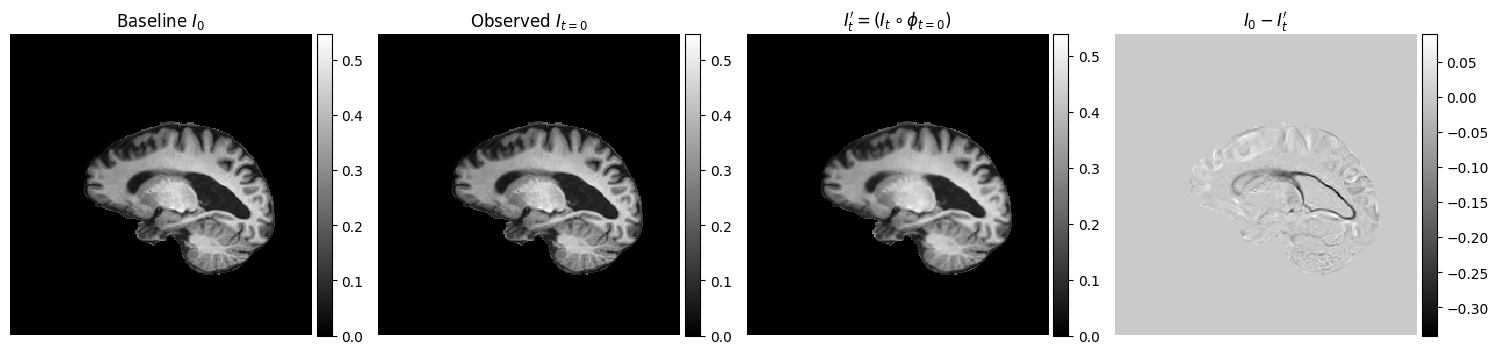

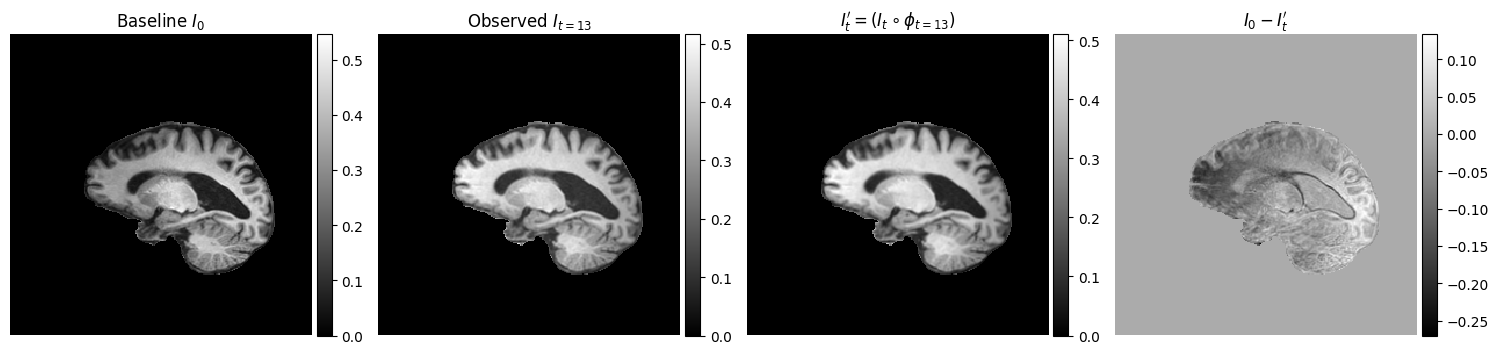

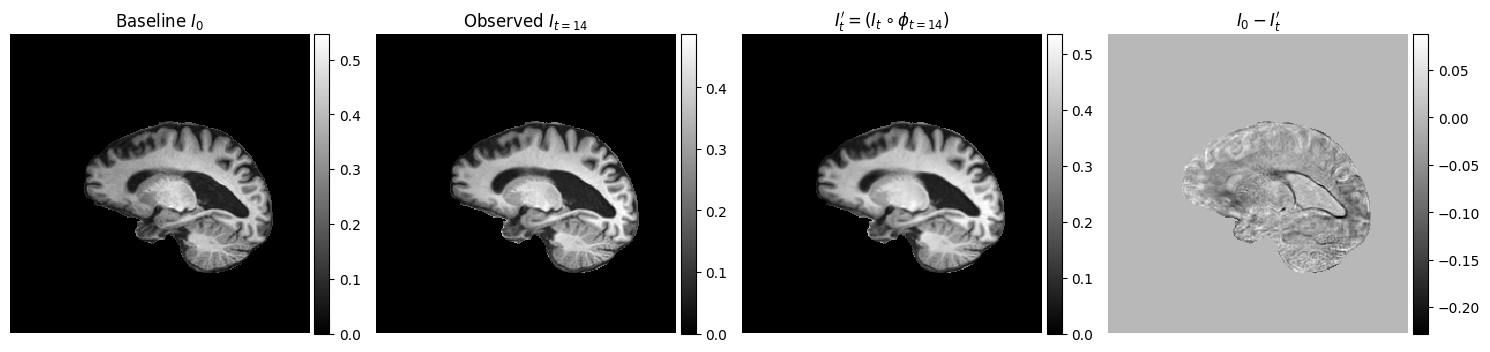

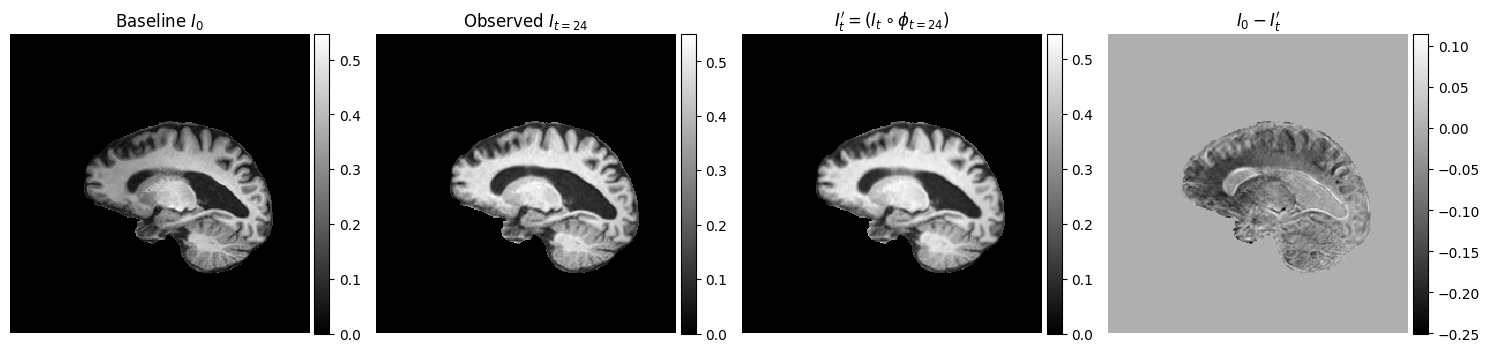

In [6]:
#visualising residuals
def image_masking(img, mask, tdf = False):

    img = (img - np.min(img))/(np.max(img) - np.min(img))
    if tdf == True:
        return img 
    return img * mask

num_slice = 120
image_mask_2d = I0_mask[:, :, num_slice]
I0_2d = I0[:, :, num_slice]
masked_I0 = image_masking(I0_2d, image_mask_2d, False)

video_images = []
video_titles = []
for idx, t in enumerate(observed_time_points):
    img = It[idx]
    It_2d = img[:, :, num_slice]
    moved_2d = stack_moved_images[idx][:, :, num_slice]
    tdf_2d = stack_tdf[idx][:, :, num_slice].cpu().numpy()
    masked_It = image_masking(It_2d, image_mask_2d, False)

    masked_moved = image_masking(moved_2d, image_mask_2d, False)
    masked_tdf = image_masking(tdf_2d, image_mask_2d, True)
    residual = masked_I0 - masked_moved
    
    
    # images = [masked_I0, masked_It, masked_moved,  residual , masked_tdf[..., 2]] 
    images = [masked_I0, masked_It, masked_moved,  residual] 

    titles = [
    r'Baseline $I_0$', 
    r'Observed $I_{t=' + str(t) + '}$', 
    r"$I_{t}' = (I_t \circ \phi_{t=" + str(t) + "})$", 
    r"$I_0 - I_{t}'$", 
    ]
    video_images.append(images)
    video_titles.append(titles)
    ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

    wandb.log({"Transformed images": [wandb.Image(image, caption=title) for image, title in zip(images, titles)]})



## EVALUATING |J| maps

/tmp/ipykernel_1745553/3248693589.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.9])  # Adjust layout to fit title and colorbar


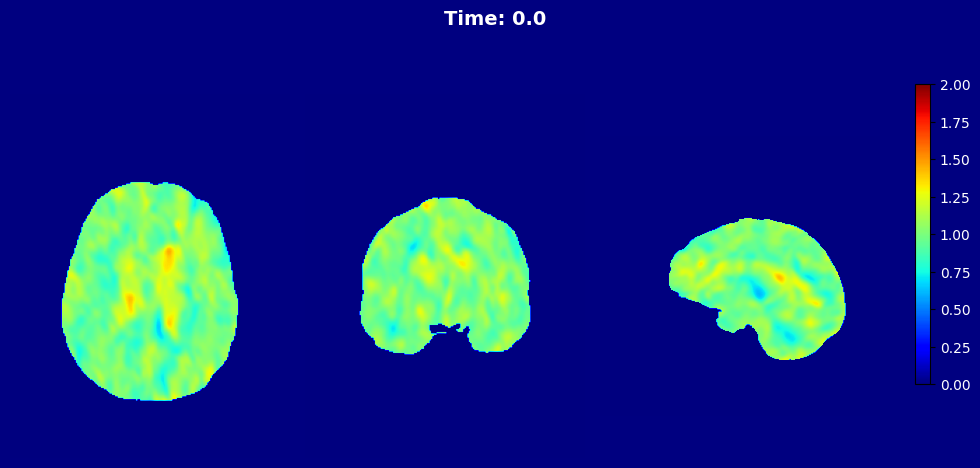

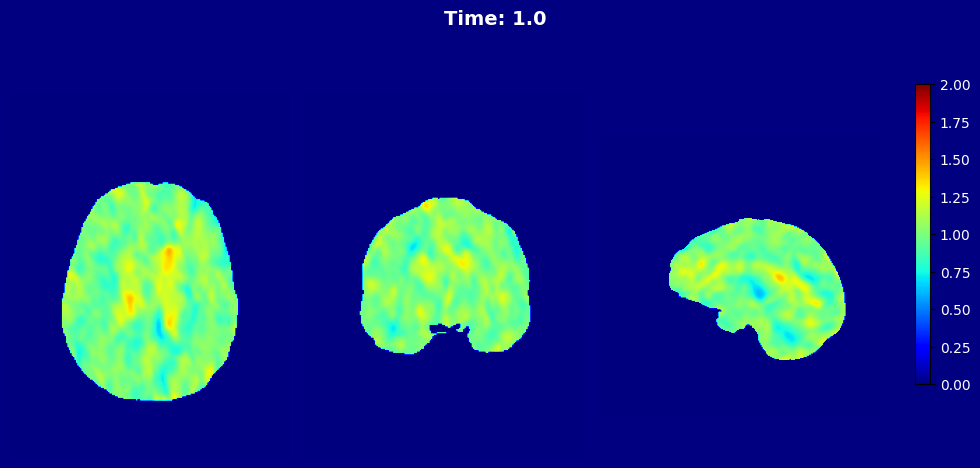

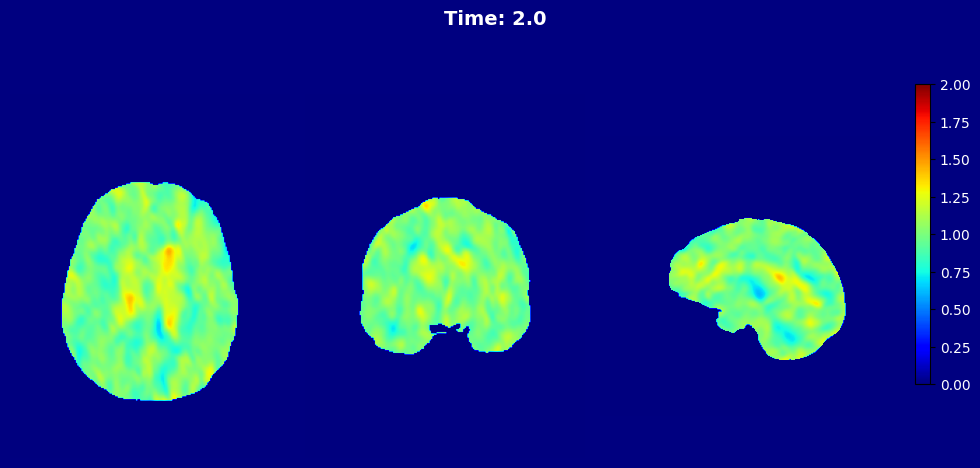

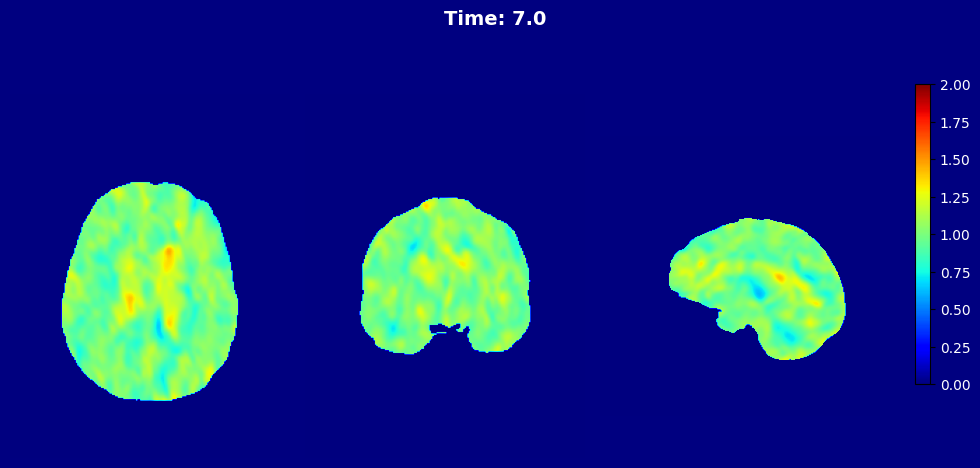

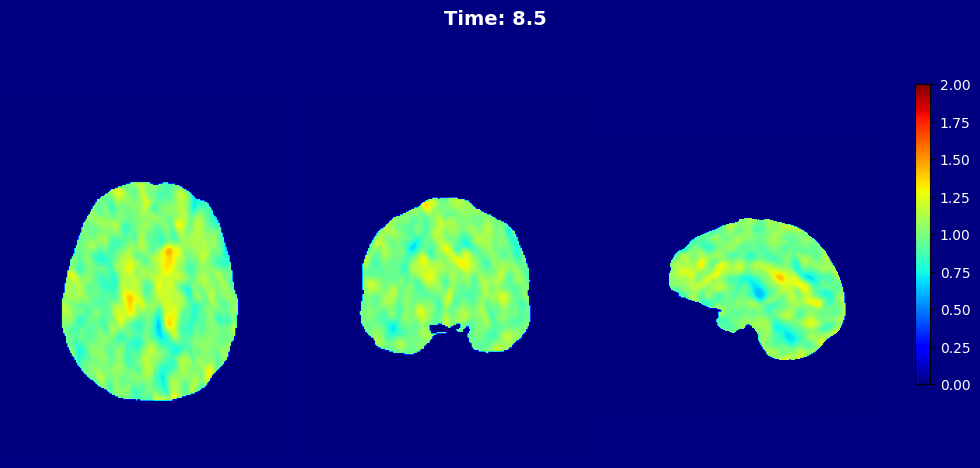

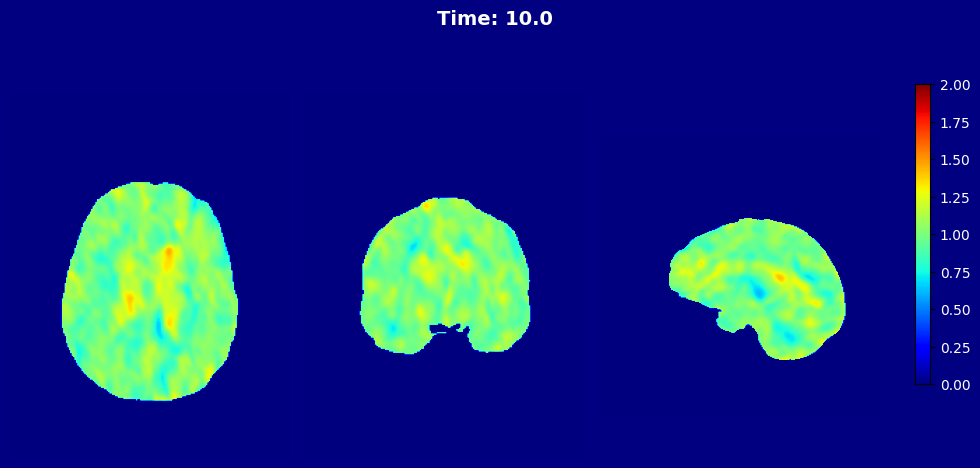

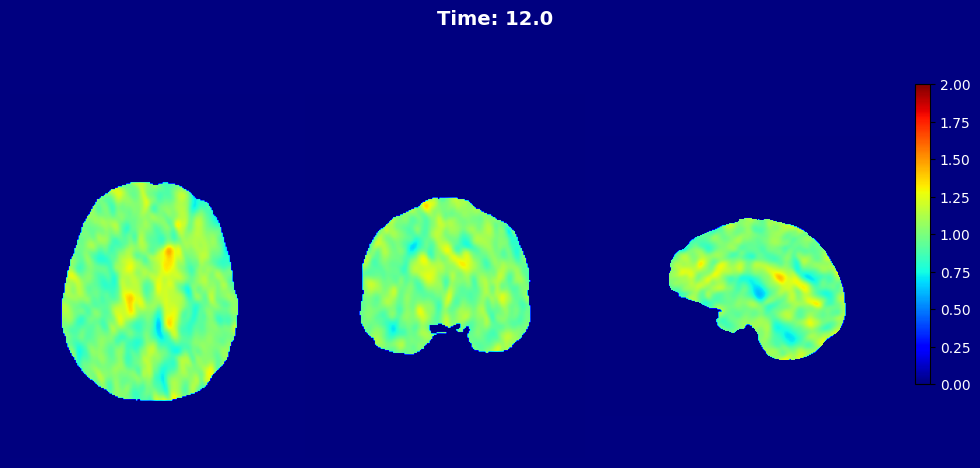

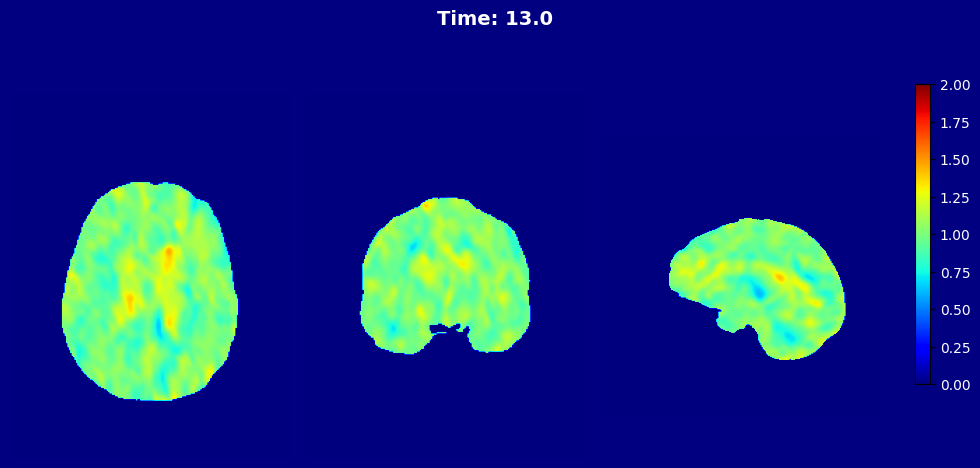

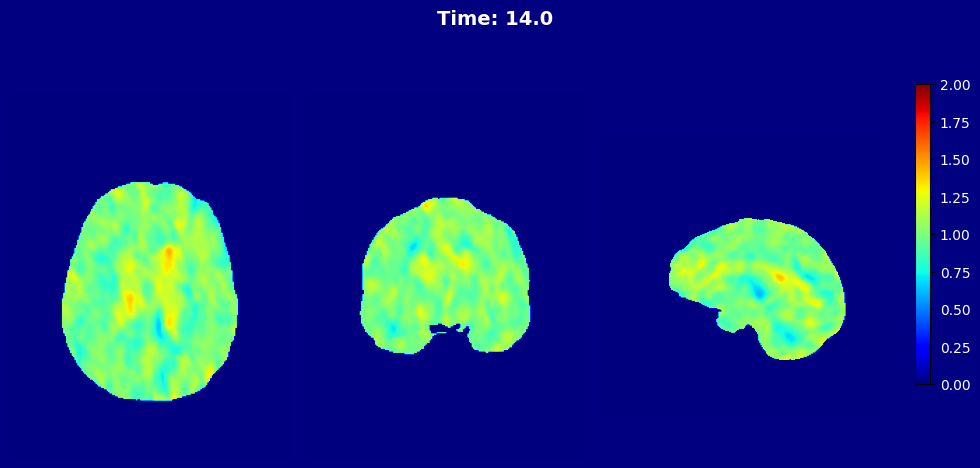

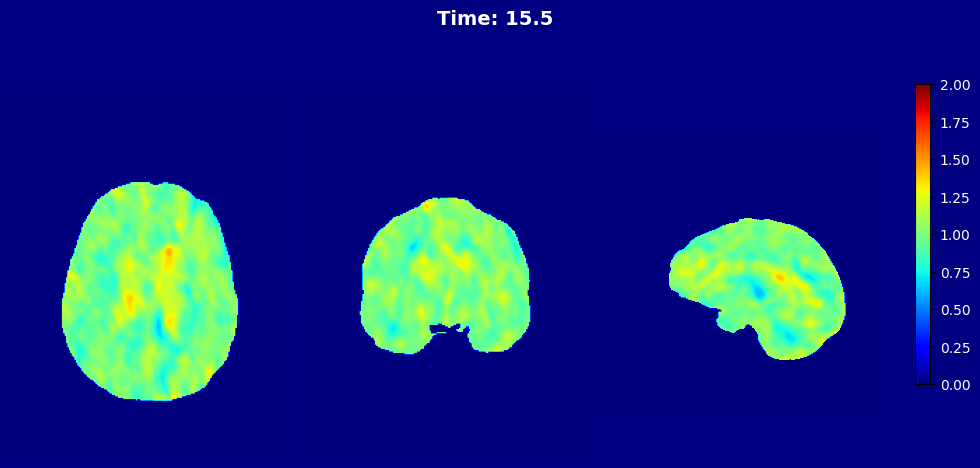

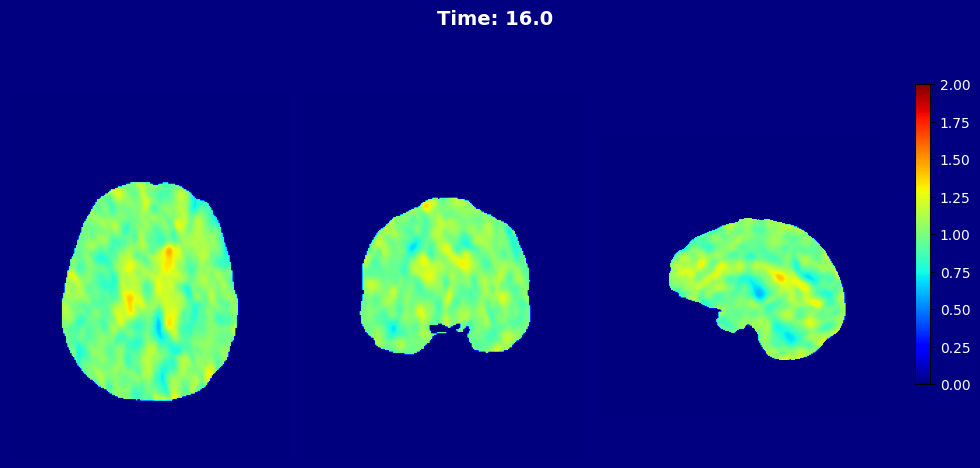

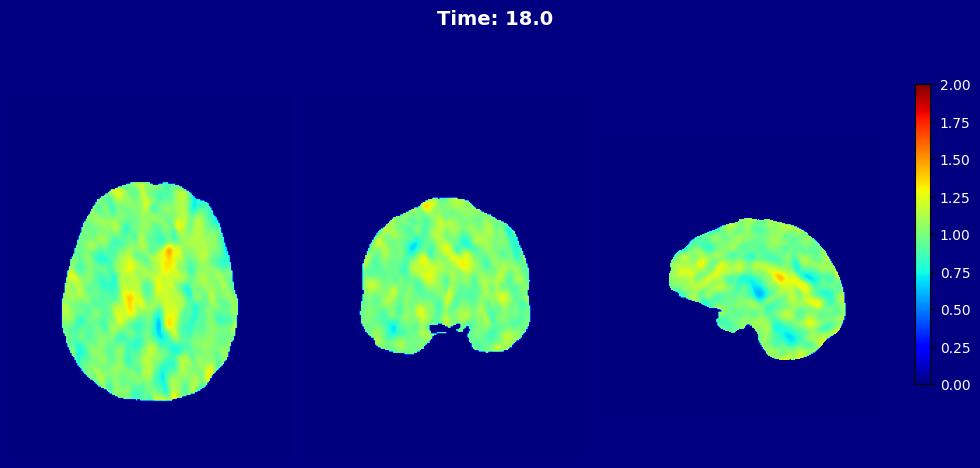

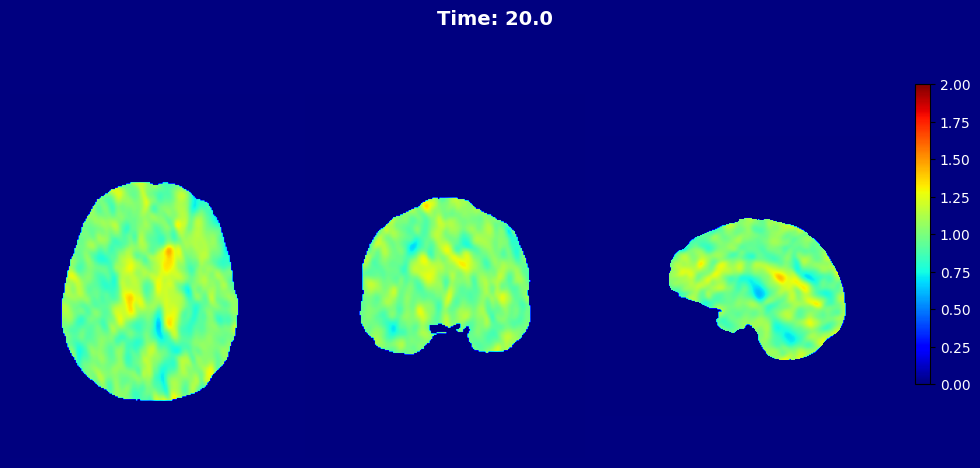

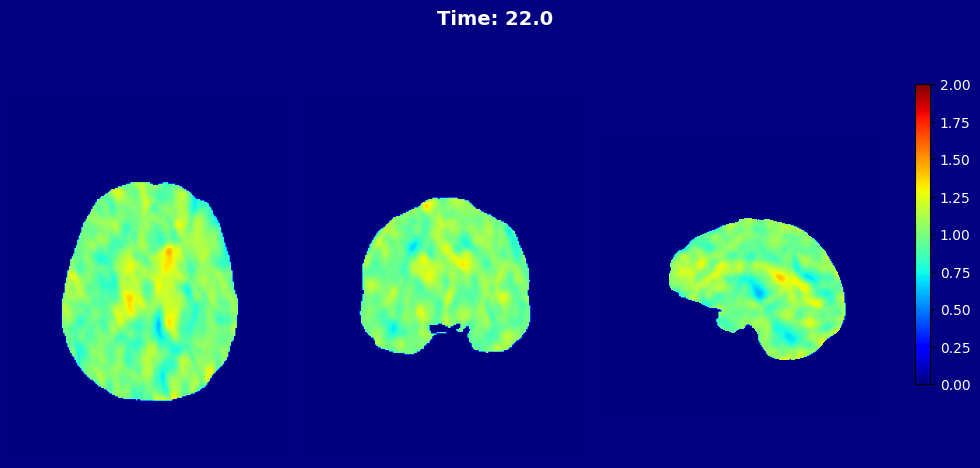

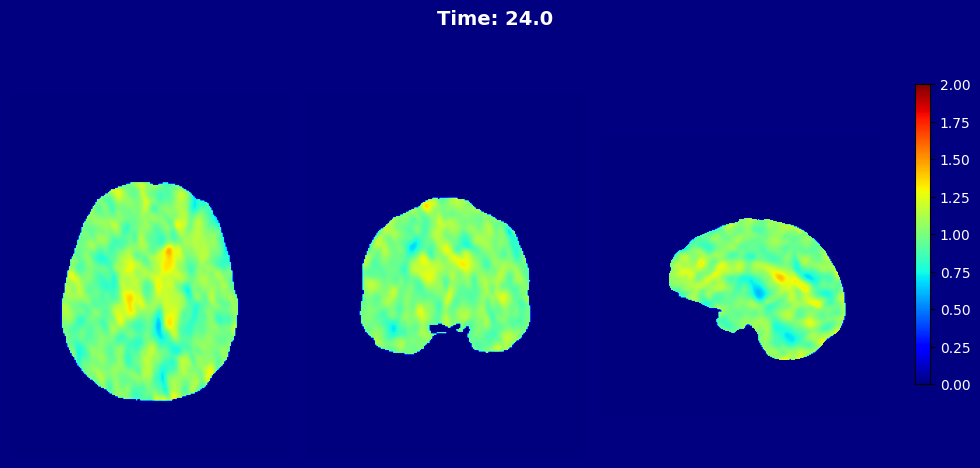

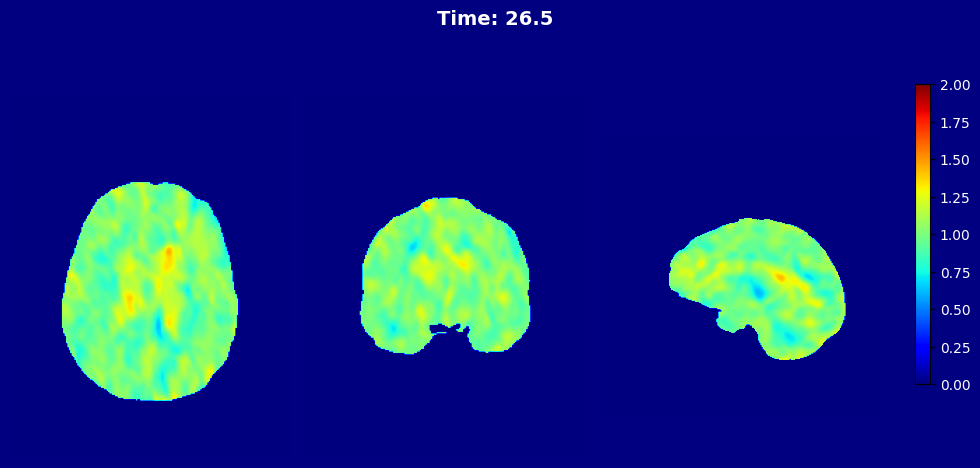

In [7]:
def preview_image(jacobian_det, mask, time, normalize_by="volume", cmap="jet", figsize=(10, 5), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Set colorbar range and background color
    vmin, vmax = 0, 2  # Fixed range for the colorbar
    background_color = (0, 0, 0.5)  # Dark blue background color (RGB normalized)

    # Define region for visualization based on mask
    rows, cols, dep = np.where(mask > 0)
    x1, x2 = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    x, y, z = 120, 125, 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize, facecolor=background_color)

    fig.suptitle(f"Time: {time}", fontsize=14, weight='bold', y=0.95, color="white")

    # Display each slice
    for idx, img in enumerate(jac_det_slices):
        ax = axs[idx]
        ax.axis("off")
        ax.set_facecolor(background_color)
        im = ax.imshow(img, origin="upper", cmap=cmap, vmin=vmin, vmax=vmax)

        # Optional: Apply threshold overlay
        if threshold is not None:
            red_overlay = np.zeros(img.shape + (4,))
            red_overlay[img <= threshold] = [1, 0, 0, 1]  # Red for below threshold
            ax.imshow(red_overlay, origin="upper")

    # Single colorbar for all slices
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # Position for colorbar, narrower and more compact
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelcolor='white')  # White color for colorbar ticks

    # Adjust layout for even tighter spacing
    plt.subplots_adjust(wspace=0.01, left=0.05, right=0.85)  # Minimal space between slices and set tighter margins

    plt.tight_layout(rect=[0, 0, 0.9, 0.9])  # Adjust layout to fit title and colorbar
    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig

# Loop through time points
video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    fig = preview_image(det, I0_mask, selected_time, normalize_by="slice", threshold=-1)
    video_jacobian_maps.append(fig)
plt.close(fig)


In [ ]:
def preview_image(jacobian_det, mask, I0, time, normalize_by="volume", cmap=None, figsize=(12, 12), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin = None
        vmax = None
        
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        # vmax = jacobian_det.max().item()
        vmax = jacobian_det.max().item()

    else:
        raise (ValueError(f"Invalid value '{normalize_by}' given for normalize_by"))

    # half-way slices
    rows, cols, dep = np.where(mask > 0)
    x1, x2, = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    # x, y, z = np.array(jacobian_det.shape) // 2
    x = 120
    y = 125
    z = 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    I0_slices = (I0[x, :, :], I0[:, y, :], I0[:, :, z])

    # jac_det_slices = (jacobian_det[x, y1:y2, z1:z2], jacobian_det[x1:x2, y, z1:z2], jacobian_det[x1:x2, y1:y2, z])

    # I0_slices = (I0[x, y1:y2, z1:z2], I0[x1:x2, y, z1:z2], I0[x1:x2, y1:y2, z])
    fig, axs = plt.subplots(2, 3, figsize=figsize)

    for i, (img, I0_slice) in enumerate(zip(jac_det_slices, I0_slices)):
        ax = axs[0, i]
        ax.axis("off")
        gg = ax.imshow(img, origin="upper", cmap="RdBu") #cmap coolwarm, RdBu, jet

        if threshold is not None:
            red = np.zeros(img.shape + (4,))  # RGBA array
            red[img <= threshold] = [1, 0, 0, 1]
            ax.imshow(red, origin="upper")

        # Add colorbar for the image slice
        cbar = fig.colorbar(gg, ax=ax, fraction=0.046, pad=0.05)
        # cbar.ax.tick_params(labelsize=8)

        ax = axs[1, i]
        ax.axis("off")
        hh = ax.imshow(I0_slice, origin="upper", cmap="gray")


        # Add colorbar for the I0 slice
        cbar = fig.colorbar(hh, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        fig.tight_layout()
        
        text = f"""
        Time: {time}
        Number of folds: {(det<=0).sum()}
        Number of expansion: {(det>1).sum()}
        Number of contraction: {((det > 0) & (det < 1)).sum()}
        Number of voxels without change: {(det==1).sum()}
        |J| min, max and mean: {float(det.min().item()):.2f}, {float(det.max().item()):.2f}, {float(det.mean().item()):.3f}
        
        """
    ax.set_facecolor("yellow")
    plt.figtext(0.7, 0.90, text, ha="left", fontsize=10, bbox={"facecolor": "white", "edgecolor": "white", "alpha": 0, "pad": 5, "linewidth": 3})
    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig


video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] 
    mvd = stack_moved_images[idx]
    mvd = (mvd - np.min(mvd))/(np.max(mvd) - np.min(mvd))
    mvd = mvd * I0_mask
    fig =preview_image(det, I0_mask, mvd, selected_time, normalize_by="slice", threshold=0)
    video_jacobian_maps.append(fig)
plt.close(fig)

In [ ]:
def preview_image(jacobian_det, mask, I0, time, normalize_by="slice", cmap="jet", alpha=0.5, figsize=(12, 12), threshold=None):
    """
    Display three orthogonal slices of the given 3D image with an overlay of the masked Jacobian determinant map.

    jacobian_det is assumed to be of shape (H, W, D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin, vmax = None, None
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        vmax = jacobian_det.max().item()
    else:
        raise ValueError(f"Invalid value '{normalize_by}' given for normalize_by")

    #half-way slices
    x, y, z = 120, 125, 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])
    I0_slices = (I0[x, :, :], I0[:, y, :], I0[:, :, z])
    mask_slices = (mask[x, :, :], mask[:, y, :], mask[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    for i, (jac_slice, I0_slice, mask_slice) in enumerate(zip(jac_det_slices, I0_slices, mask_slices)):
        #plot the base grayscale image (unmasked)
        ax = axs[i]
        jac_slice = 1/jac_slice #invert the Jacobian determinant for correct visualization
        ax.imshow(I0_slice, origin="upper", cmap="gray")

        #mask the Jacobian map
        jac_slice_masked = np.ma.masked_where(mask_slice == 0, jac_slice)
        #make min and max values per slice
        vmin = jac_slice_masked.min()
        vmax = jac_slice_masked.max()
        #overlay the masked Jacobian map
        overlay = ax.imshow(jac_slice_masked, origin="upper", cmap=cmap,alpha=alpha, vmin=vmin, vmax=vmax)
        #add colorbar for the overlay
        cbar = fig.colorbar(overlay, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

        # # Optional: apply threshold for highlighting areas in red
        # if threshold is not None:
        #     red = np.zeros(jac_slice.shape + (4,))  # RGBA array
        #     red[jac_slice <= threshold] = [1, 0, 0, 1]
        #     ax.imshow(red, origin="upper")

    fig.tight_layout()
    plt.show()
    return fig

video_jacobian_determinant_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    mvd = stack_moved_images[idx]
    mvd = (mvd - np.min(mvd))/(np.max(mvd) - np.min(mvd))
    mvd = mvd * I0_mask
    fig =preview_image(det, I0_mask, I0, selected_time, normalize_by="slice", threshold=0)
    video_jacobian_determinant_maps.append(fig)
plt.close(fig)

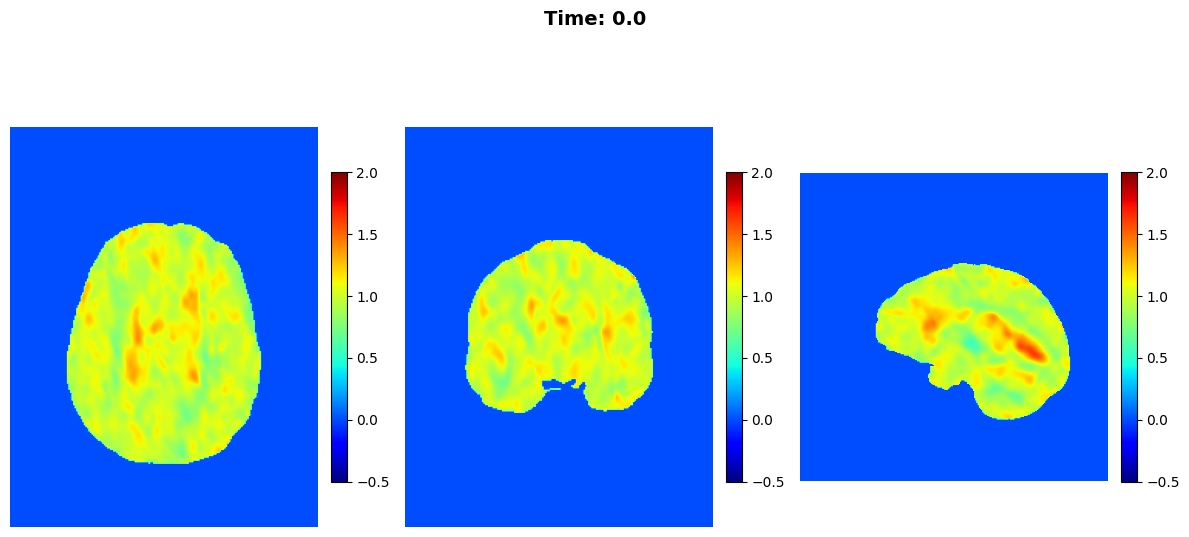

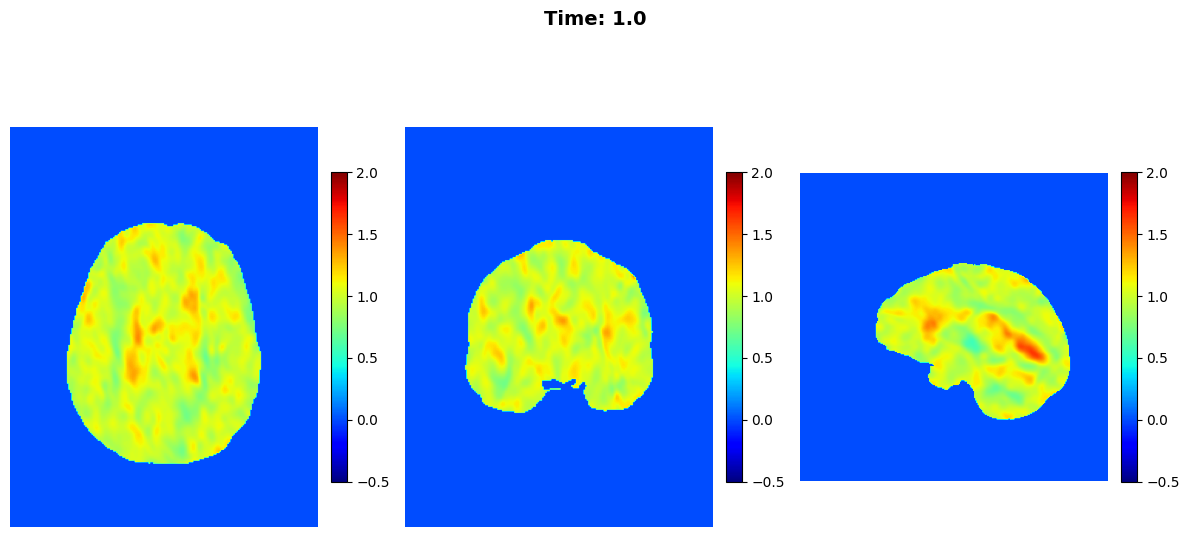

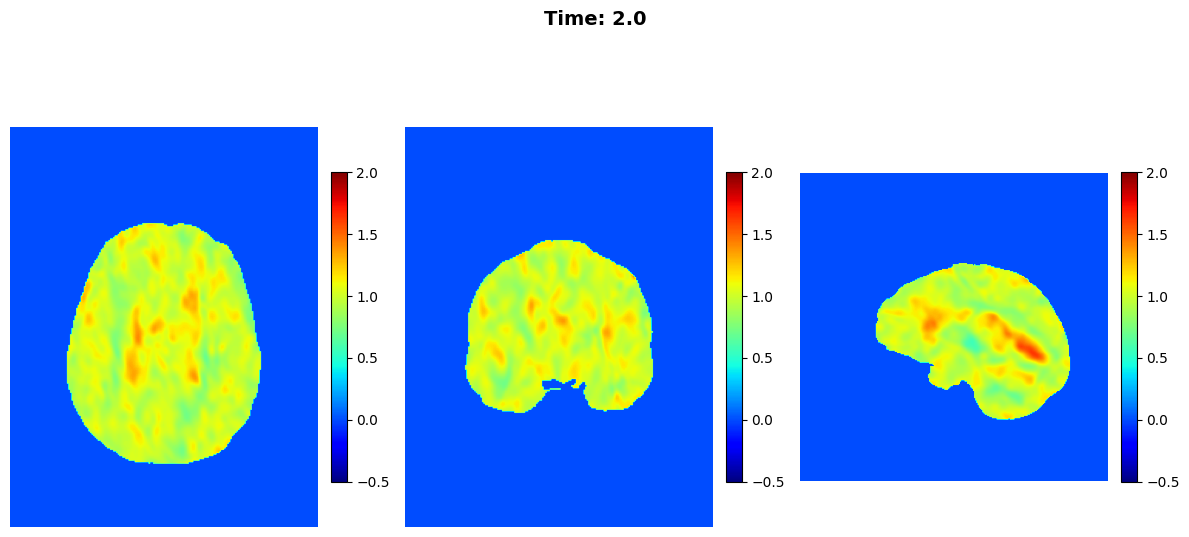

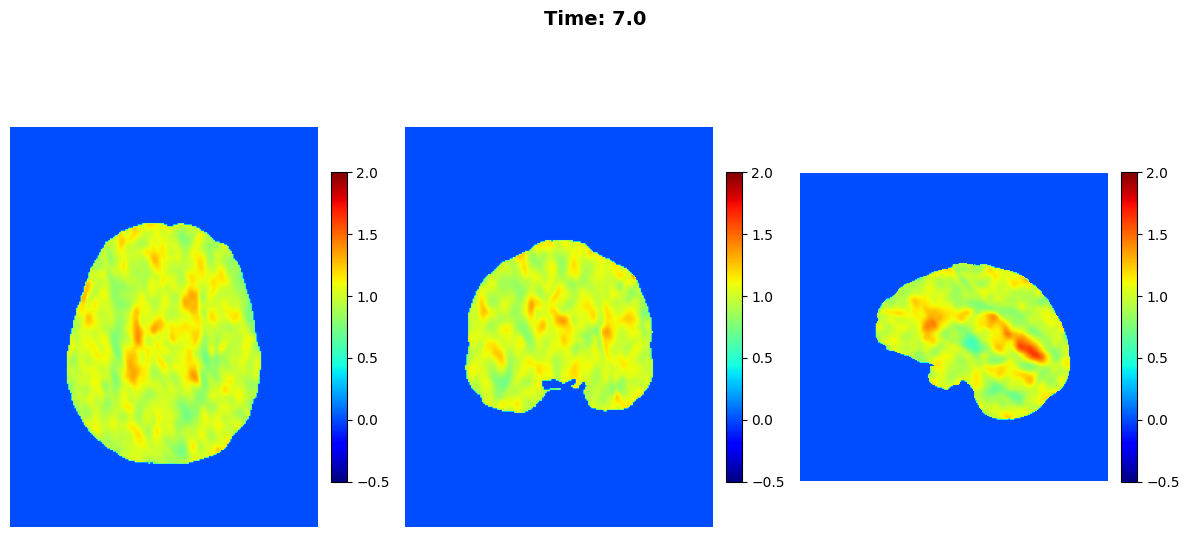

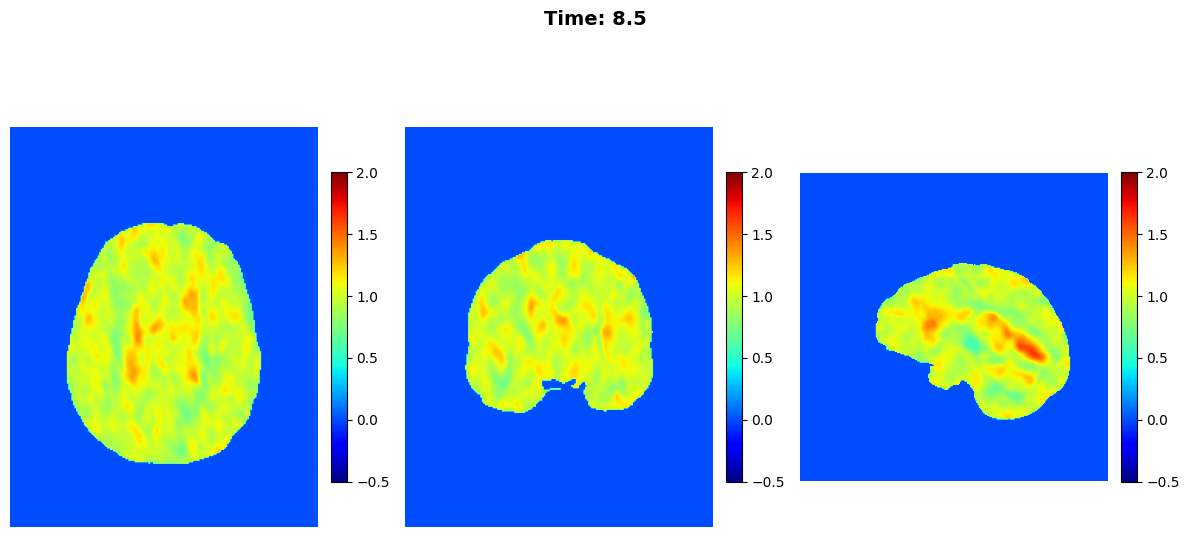

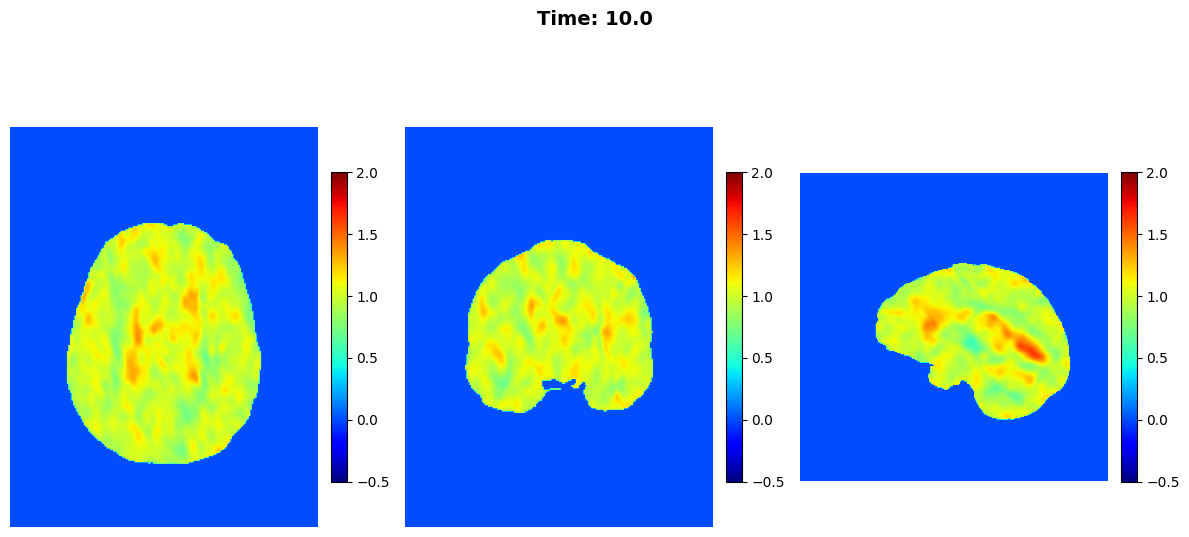

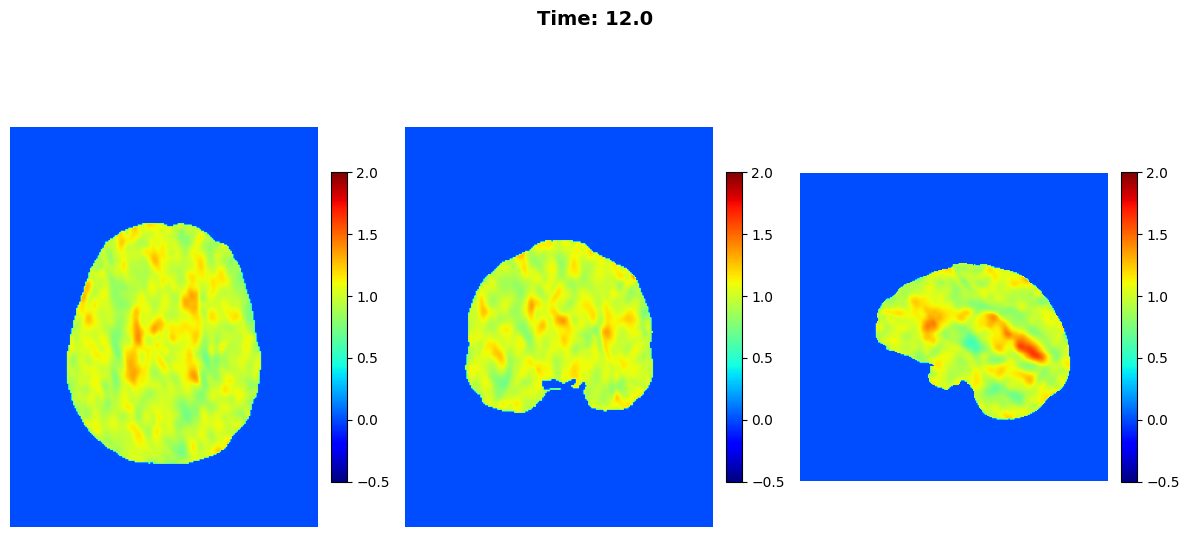

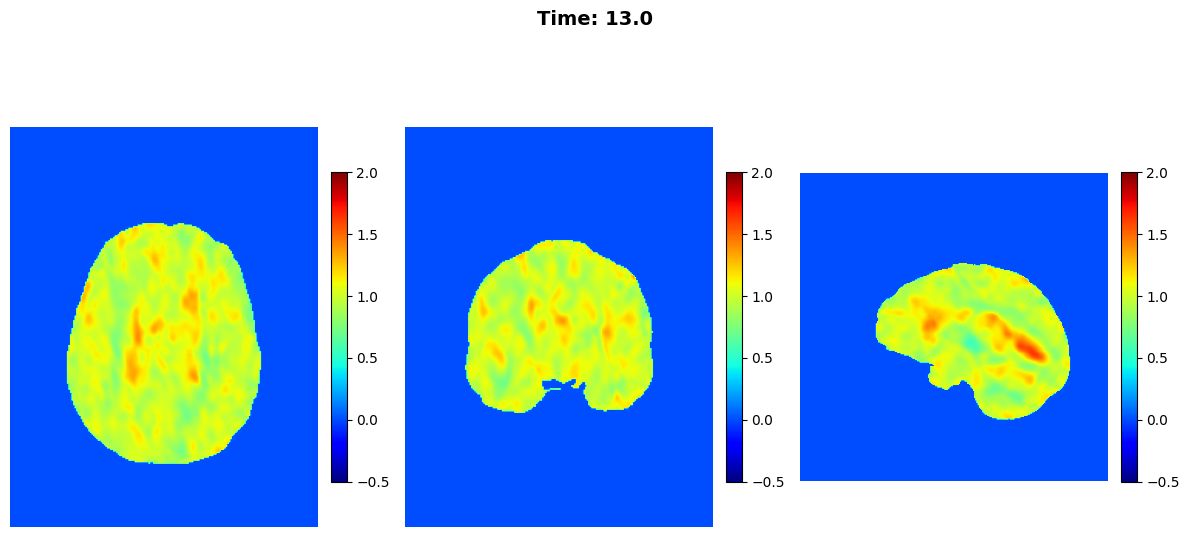

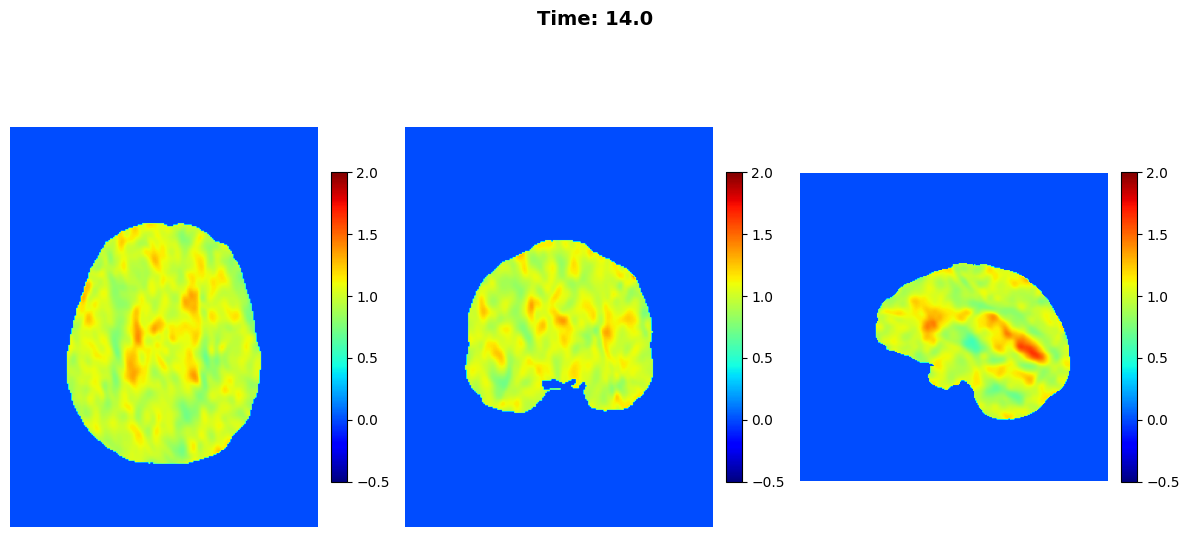

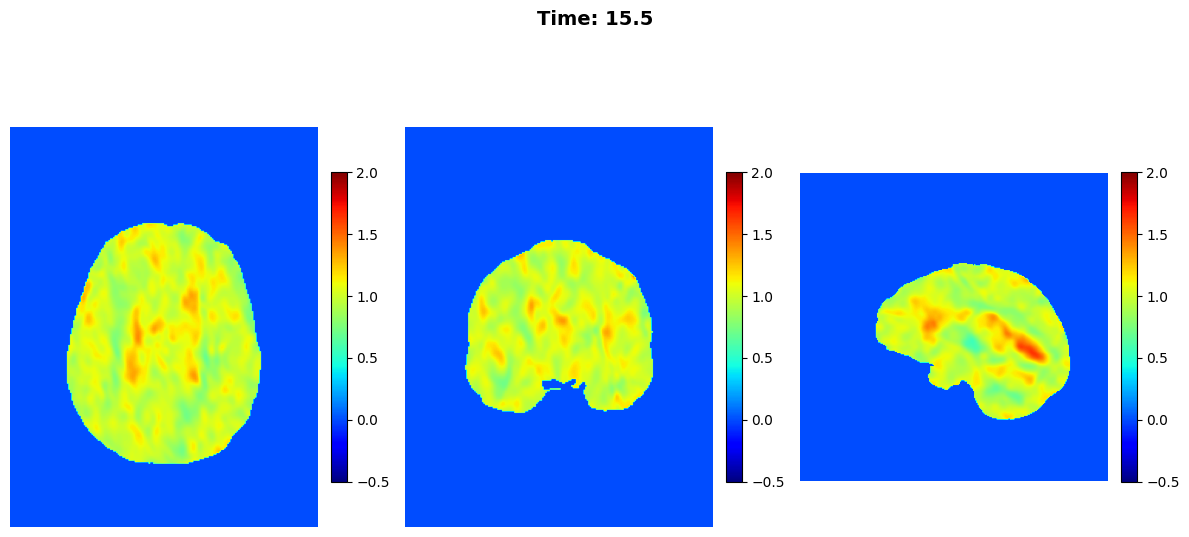

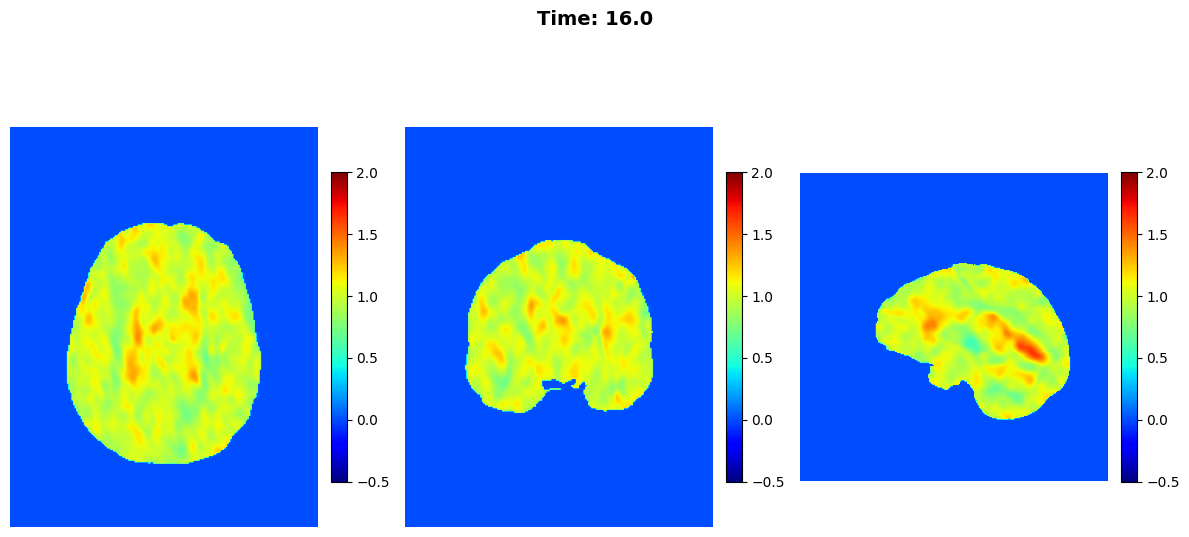

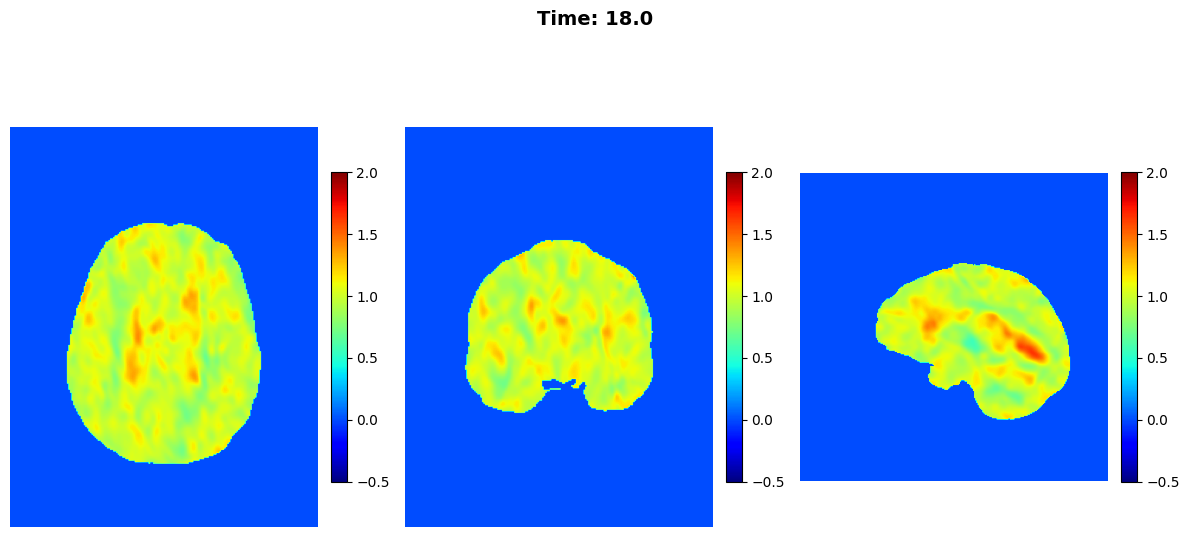

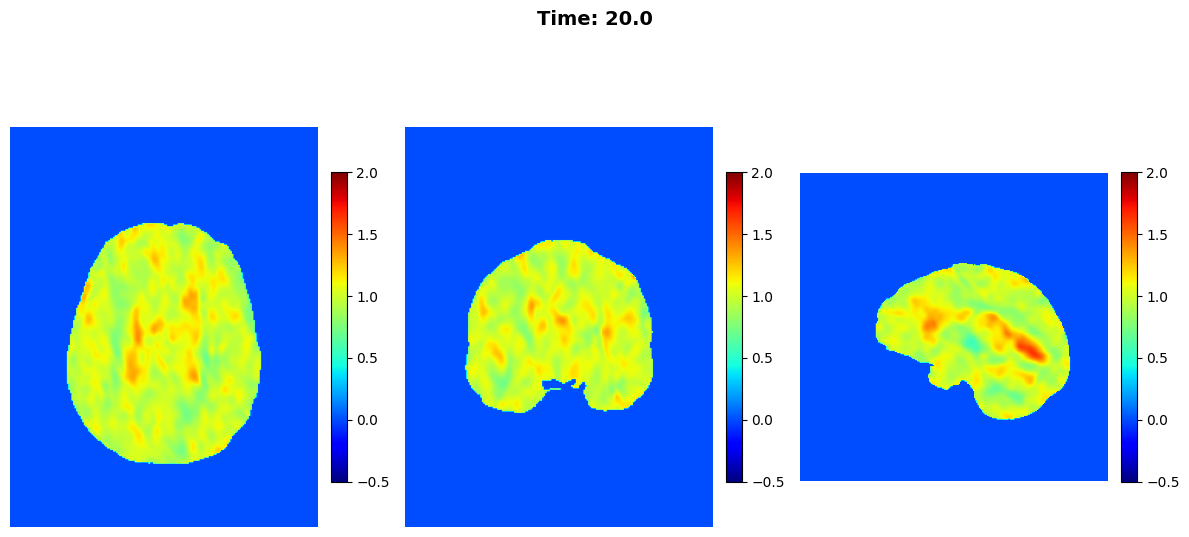

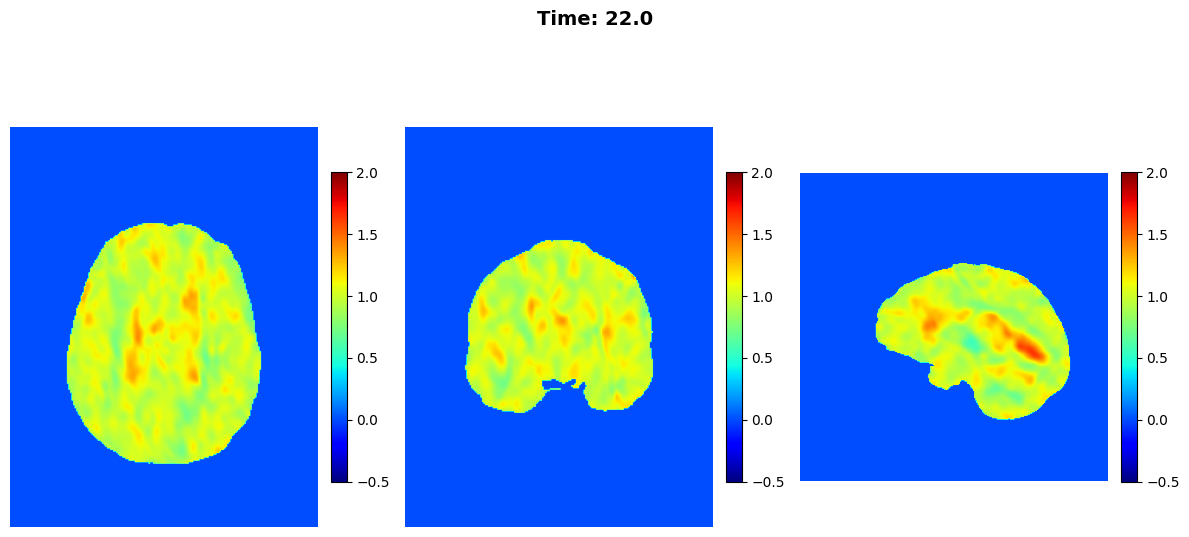

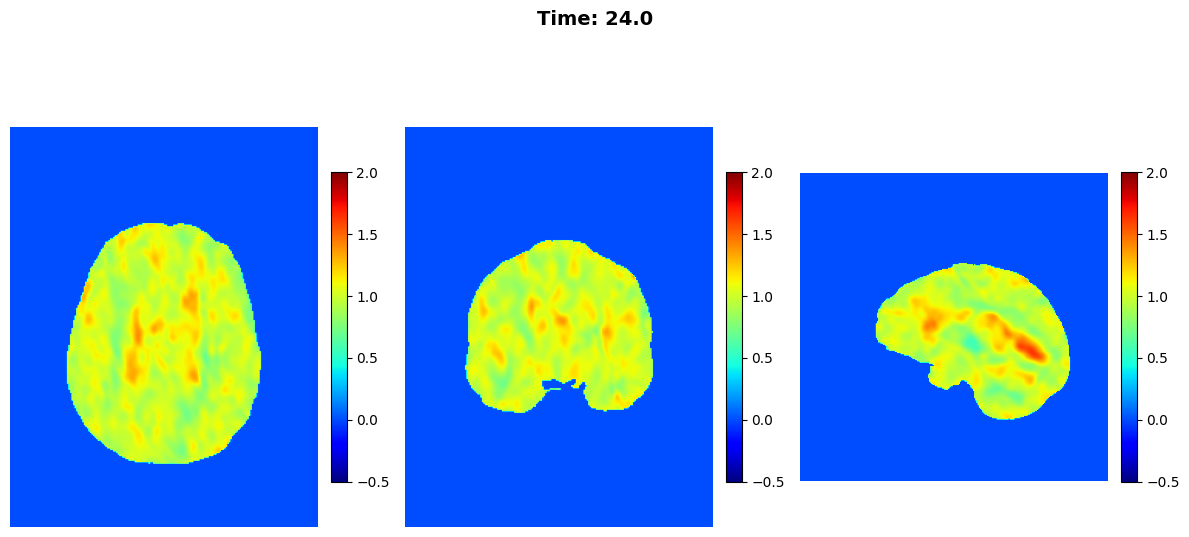

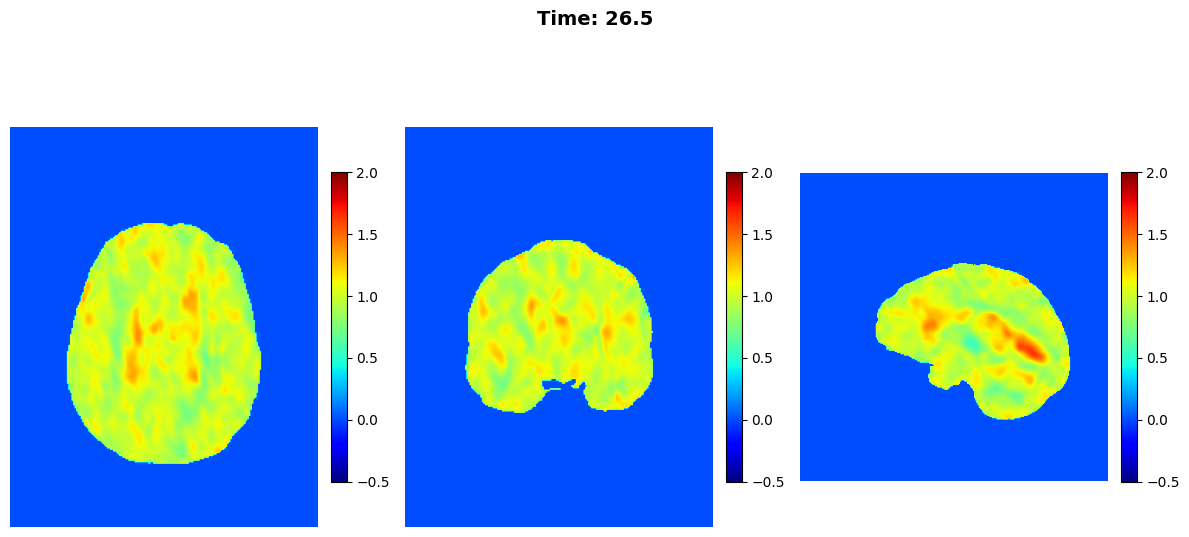

In [7]:
def preview_image(jacobian_det, mask, time, normalize_by="volume", cmap="jet", figsize=(12, 6), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    if normalize_by == "slice":
        vmin = -0.5
        vmax = 2
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        vmax = jacobian_det.max().item()
    else:
        raise ValueError(f"Invalid value '{normalize_by}' given for normalize_by")

    #define region for visualization based on mask
    rows, cols, dep = np.where(mask > 0)
    x1, x2 = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    x, y, z = 120, 125, 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f"Time: {time}", fontsize=14, weight='bold', y=0.95)

    for idx, img in enumerate(jac_det_slices):
        ax = axs[idx]
        ax.axis("off")
        gg = ax.imshow(img, origin="upper", cmap=cmap or "RdBu", vmin=vmin, vmax=vmax)

        if threshold is not None:
            red_overlay = np.zeros(img.shape + (4,))
            red_overlay[img <= threshold] = [1, 0, 0, 1]  #red for below threshold
            ax.imshow(red_overlay, origin="upper")

        # Add colorbar to each subplot
        fig.colorbar(gg, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.9])  #adjust layout to fit suptitle and subplots

    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig

video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    fig = preview_image(det, I0_mask, selected_time, normalize_by="slice", threshold=-1)
    video_jacobian_maps.append(fig)
plt.close(fig)


### SEGMENTATION MAPS

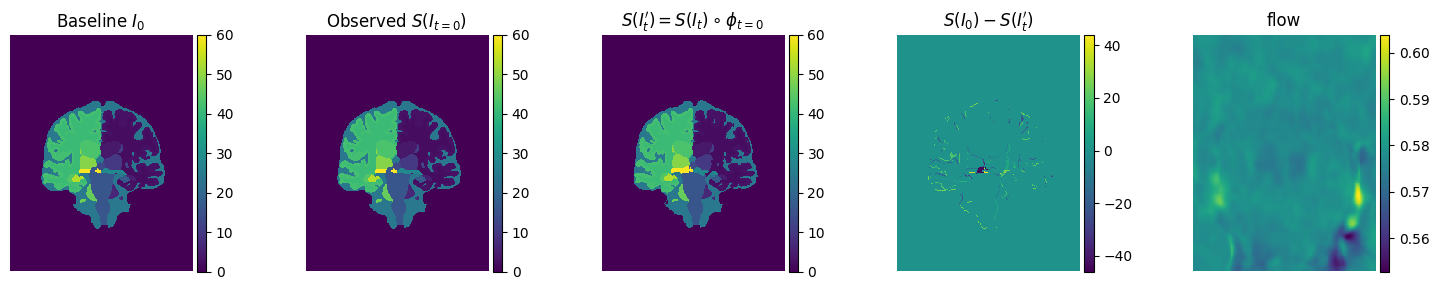

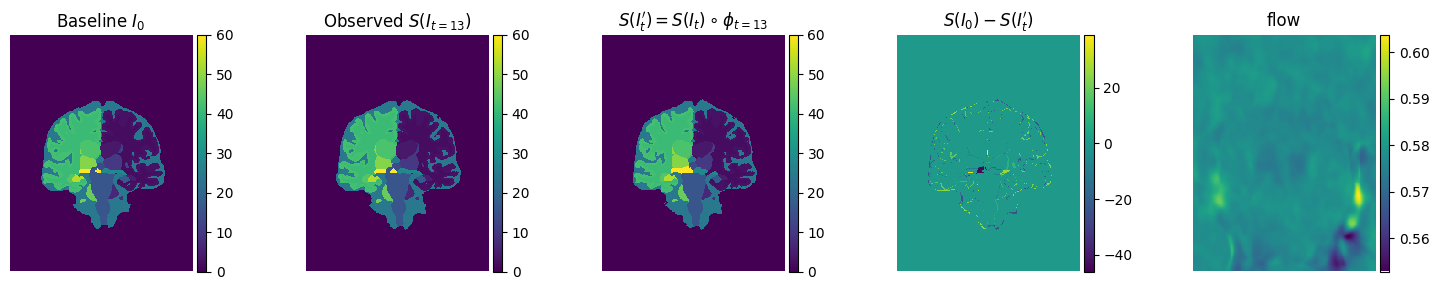

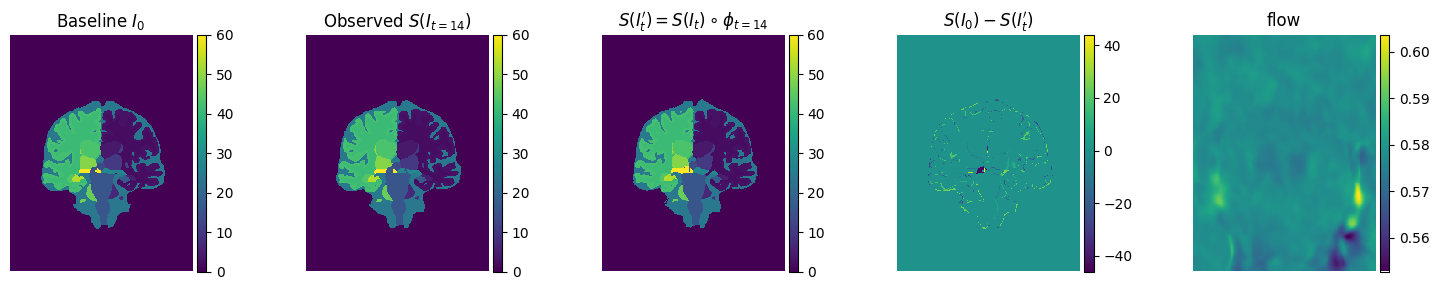

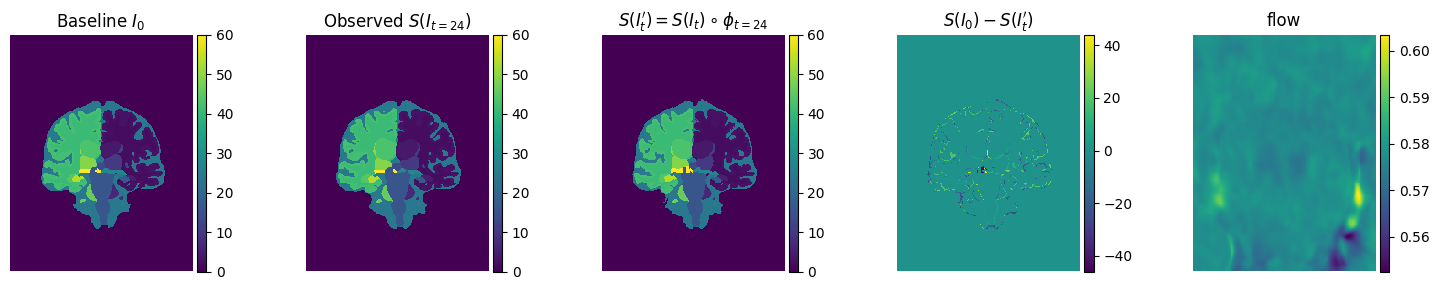

In [9]:
#warp the labbeled I0 with deformation field to compute dice between moved_I0 and It_seg


stack_moved_seg = []
video_images_seg = []
video_titles_seg = []
z = 150
data = sorted(glob.glob(datapath + "../labels/I*"))
labels = [load_data(img, False) for img in data]
I0_seg = labels[0]
It_seg = labels

image_mask_2d_seg = I0_mask[:, z, :] 
I0_2d_seg = I0_seg[:, z, :].cpu().numpy()


for idx, selected_time in enumerate(observed_time_points):
    img_seg = It_seg[idx]

    moved_seg = transform.nearest_neighbor_interpolation(stack_total_deformation_field[idx].to(device), img_seg).view(img_seg.shape)  
    stack_moved_seg.append(moved_seg.cpu().numpy().squeeze())


    It_2d_seg = img_seg[:, z, :].cpu().numpy()
    moved_2d_label = moved_seg[:, z, :].cpu().numpy()

    residual = I0_2d_seg -  moved_2d_label
    
    tdf_2d = stack_tdf[idx][:, z, :].cpu().numpy()
    masked_tdf = image_masking(tdf_2d, image_mask_2d, True )

    images = [I0_2d_seg, It_2d_seg, moved_2d_label,  residual, masked_tdf[..., 1]] 
    titles = [
        r'Baseline $I_0$', 
        r'Observed $S(I_{t=' + str(selected_time) + '})$', 
        r"$S(I_{t}') = S(I_t)  \circ \phi_{t=" + str(selected_time) + "}$", 
        r"$S(I_0) - S(I_{t}')$",
        'flow'
    ]
    video_images_seg.append(images)
    video_titles_seg.append(titles)
    
    ne.plot.slices(images, titles=titles, do_colorbars=True,  cmaps=['viridis']);

    wandb.log({"Transformed segmentation maps": [wandb.Image(image, caption=title) for image, title in zip(images, titles)]})




In [10]:
# structures = [
#     "lateral_ventricle",
#     "thalamus",
#     "caudate",
#     "putamen",
#     "pallidum",
#     "hippocampus",
#     "amygdala"
# ]
structures = [
    "lateral_ventricle",
    "thalamus",
    "hippocampus",
    "amygdala"
]

left_structures = [4, 10, 11, 12, 13, 17, 18]
right_structures = [43, 49, 50, 51, 52, 53, 54]
result_path = "result/"+logger_name+".csv"

def dice_score(label1, label2):
    intersection = np.sum(label1[label1 > 0] == label2[label1 > 0])
    dice = (2 * intersection) / (np.sum(label1) + np.sum(label2))
    return dice

def combine_labels(img1, img2, state = "Dice Score"):

    total_dice = 0
    structure_dice = {}

    for i, structure in enumerate(structures):
        img1_combined = np.where(np.isin(img1, [left_structures[i], right_structures[i]]), 1, 0)
        img2_combined = np.where(np.isin(img2, [left_structures[i], right_structures[i]]), 1, 0)
        dice = dice_score(img1_combined, img2_combined)
        structure_dice[structure] = dice
        # print(f"{structure}: {dice:.4f}")
        total_dice+=dice
    print(f" {state} : {total_dice/len(structures)}")
    return structure_dice, total_dice/len(structures)

def combine_labels(img1, img2, selected_time, state = "Dice Score"):
    total_dice = 0
    structure_dice = {}

    for i, structure in enumerate(structures):
        img1_combined = np.where(np.isin(img1, [left_structures[i], right_structures[i]]), 1, 0)
        img2_combined = np.where(np.isin(img2, [left_structures[i], right_structures[i]]), 1, 0)
        dice = dice_score(img1_combined, img2_combined)
        structure_dice[structure] = dice
        # print(f"{structure}: {dice:.4f}")
        total_dice+=dice
    print(f"Time = {selected_time}, {state} : {total_dice/len(structures)}")
    return structure_dice, total_dice/len(structures)


def compute_mean_jac_det(moved_label, det, selected_time):
    mean_jacobian_determinants = {}
    for i, structure in enumerate(structures):
        mask =  np.where(np.isin(moved_label, [left_structures[i], right_structures[i]]), 1, 0)
        
        jacobian_values = det[mask > 0]
        mean_jacobian_determinants[structure] = jacobian_values.mean().item()
    return mean_jacobian_determinants

for idx, selected_time in enumerate(observed_time_points):
    It_seg = load_data(datapath +f"../labels/I{idx}_seg.nii", False)
    It_seg = It_seg.cpu().numpy()
         
    structure_dice_affine, total_dice_affine = combine_labels(I0_seg.cpu().numpy(), It_seg, selected_time,"Dice between I0 and It (affine)")
    structure_dice_target_predicted, total_dice_target_predicted = combine_labels(I0_seg.cpu().numpy(),stack_moved_seg[idx],  selected_time, "Dice at I0 and It\'(target vs predicted)")

    det = stack_total_jac_det[idx]
    mean_jac_det = compute_mean_jac_det(stack_moved_seg[idx], det, selected_time)
    number_of_folds = (det<=0).sum().item()
    number_of_expansions = (det>1).sum().item()
    number_of_contractions= ((det > 0) & (det < 1)).sum().item()
    no_volume_change =  (det==1).sum().item()

    if not os.path.exists(result_path):
        with open(result_path, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(["subjectID", "selected_time", "structure", "structure_mean_jac_det", "jac_det_mean","jac_det_min", "jac_det_max","structure_dice_affine", "structure_dice_target_predicted",
                            "total_dice_affine", "total_dice_target_predicted", "number_of_folds", "number_of_expansions", "number_of_contractions", "no_volume_change"])

    try:

        with open(result_path, 'a') as f:
                
            for i, structure in enumerate(structures):
                writer = csv.writer(f)
                rows = [datapath.split("/")[2], selected_time, structure, mean_jac_det[structure], det.mean().item(),
                    det.min().item(), det.max().item(), structure_dice_affine[structure], structure_dice_target_predicted[structure], 
                    total_dice_affine, total_dice_target_predicted, number_of_folds, number_of_expansions, number_of_contractions, no_volume_change]
                writer.writerow(rows)

            
                
    except FileNotFoundError:
        print(f"Error: Could not write to file {result_path}")
    wandb.log({"Results": wandb.Table(data= pd.read_csv(result_path))})

Time = 0, Dice between I0 and It (affine) : 1.0
Time = 0, Dice at I0 and It'(target vs predicted) : 0.8727739354274253
Time = 13, Dice between I0 and It (affine) : 0.8973171534343899
Time = 13, Dice at I0 and It'(target vs predicted) : 0.9069533098978987
Time = 14, Dice between I0 and It (affine) : 0.8992818434623384
Time = 14, Dice at I0 and It'(target vs predicted) : 0.9071111844843283
Time = 24, Dice between I0 and It (affine) : 0.7761409104672978
Time = 24, Dice at I0 and It'(target vs predicted) : 0.8560843005820531


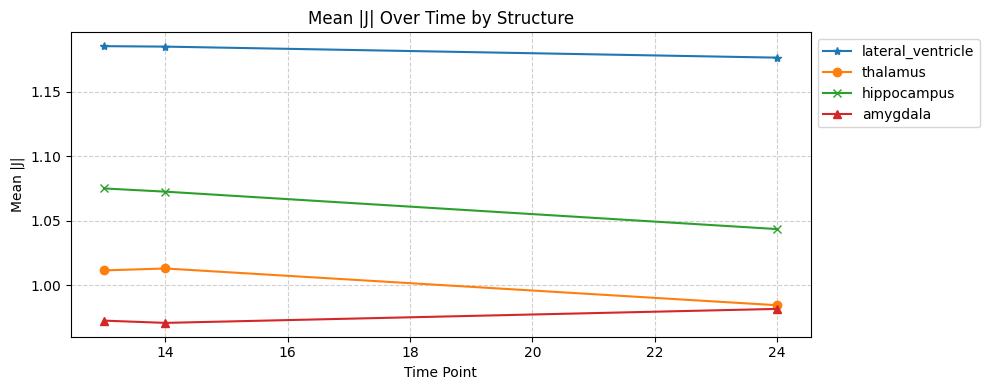

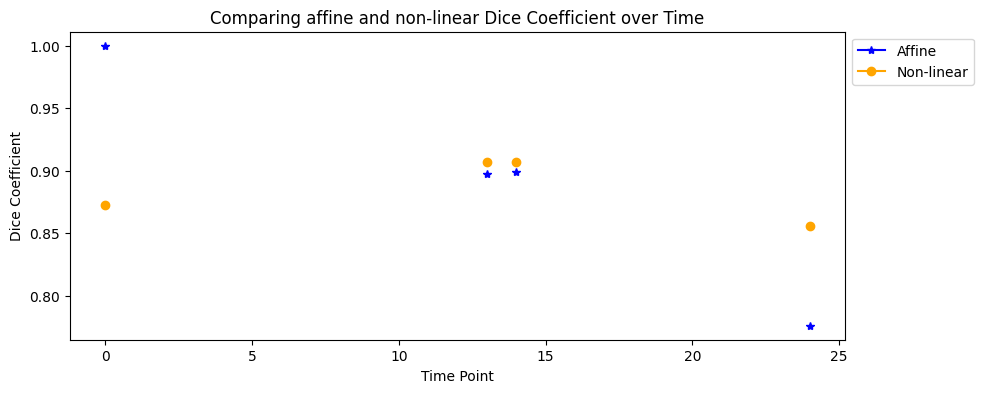

In [11]:

df = pd.read_csv(result_path)
df_filtered = df[df['selected_time'] != 0]
fig, ax = plt.subplots(figsize=(10, 4))

markers = ['*', 'o', 'x', '^', 's', 'D', 'p', '+']

for i, structure in enumerate(df_filtered['structure'].unique()):
    structure_data = df_filtered[df_filtered['structure'] == structure]
    ax.plot(structure_data['selected_time'], structure_data['structure_mean_jac_det'],
            label=structure, marker=markers[i % len(markers)], linestyle='-')

ax.set_xlabel('Time Point')
ax.set_ylabel('Mean |J|')
ax.set_title('Mean |J| Over Time by Structure')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


wandb.log({"Mean Jacobian Determinant Over time": wandb.Image(fig)})

fig, ax = plt.subplots(figsize=(10, 4))

affine_label_added = False
nonlinear_label_added = False

for time_point in df['selected_time'].unique():
    time_point_data = df[df['selected_time'] == time_point]
    # plot affine line
    ax.plot(time_point, time_point_data['total_dice_affine'].mean(), 
            marker='*', linestyle='-', color='blue', label="Affine" if not affine_label_added else "")
    affine_label_added = True
    ax.plot(time_point, time_point_data['total_dice_target_predicted'].mean(),
            marker='o', linestyle='-', color='orange', label="Non-linear" if not nonlinear_label_added else "")
    nonlinear_label_added = True

ax.set_xlabel('Time Point')
ax.set_ylabel('Dice Coefficient')
ax.set_title('Comparing affine and non-linear Dice Coefficient over Time')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#log the figure to Weights and Biases
wandb.log({"Comparing affine and non-linear Dice Coefficient over Time": wandb.Image(fig)})


### JACOBIAN DETEMINANT OVER TIME

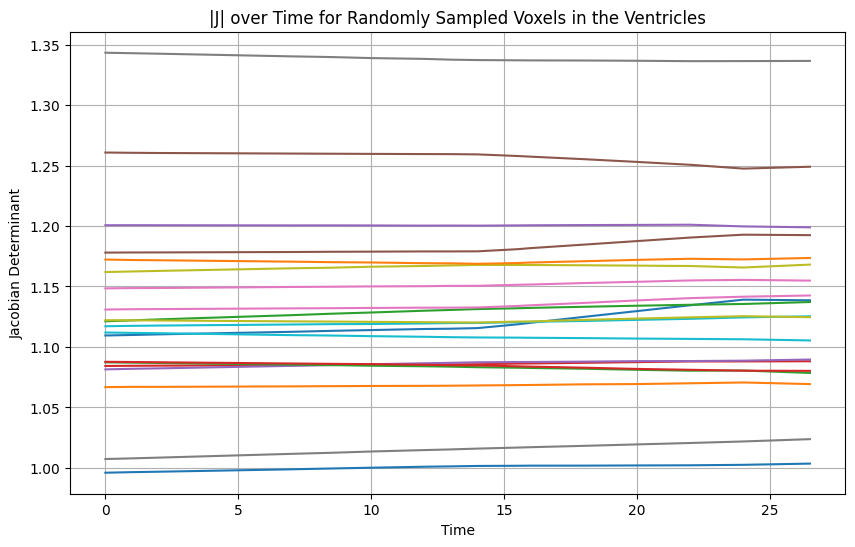

<Figure size 640x480 with 0 Axes>

In [49]:
I0_seg_np = I0_seg.cpu().numpy()

#voxel indices for the left and right ventricles
ventricle_indices = np.argwhere((I0_seg_np == 4) | (I0_seg_np == 43))

num_voxels = 20
sampled_indices = ventricle_indices[np.random.choice(len(ventricle_indices), num_voxels, replace=False)]

voxel_jacobian_values = {}

#get |J| for each time point
for t_idx, jac_det_map in enumerate(stack_total_jac_det):
    jac_det_np = jac_det_map.numpy()
    for i, (x, y, z) in enumerate(sampled_indices):
        if i not in voxel_jacobian_values:
            voxel_jacobian_values[i] = []
        voxel_jacobian_values[i].append(abs(jac_det_np[x, y, z]))

plt.figure(figsize=(10, 6))
for i, values in voxel_jacobian_values.items():
    plt.plot(time.cpu().detach().numpy(), values, label=f'Voxel {i}')

plt.xlabel('Time')
plt.ylabel('Jacobian Determinant')
plt.title('|J| over Time for Randomly Sampled Voxels in the Ventricles')
plt.grid(True)
plt.show()
wandb.log({"|J| over Time for Randomly Sampled Voxels in the Ventricles": wandb.Image(plt)})


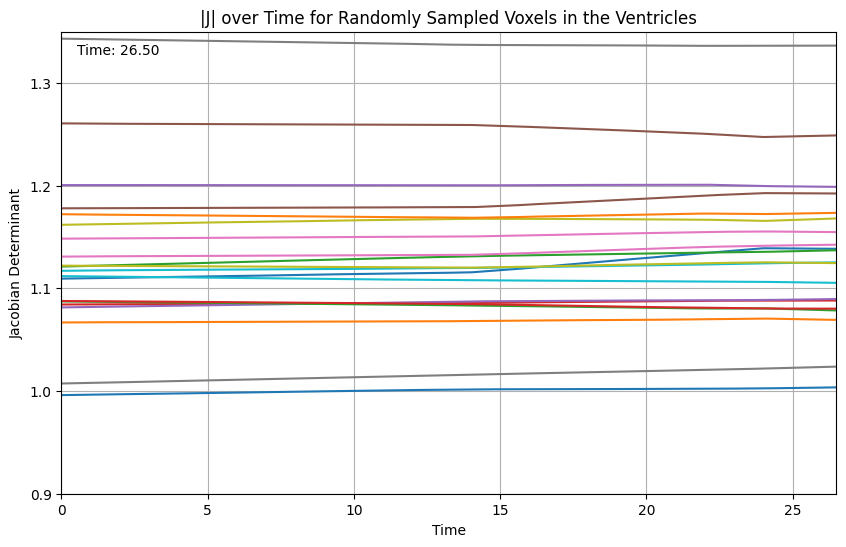

In [52]:
time_np = time.cpu().detach().numpy()

num_frames = len(time_np) * 30  # 30 fps
interpolated_time = np.linspace(time_np[0], time_np[-1], num_frames)
interpolated_voxel_values = {
    i: np.interp(interpolated_time, time_np, values)
    for i, values in voxel_jacobian_values.items()
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(time_np[0], time_np[-1])
# ax.set_ylim(0, max(max(values) for values in interpolated_voxel_values.values()) * 1.1)
ax.set_ylim(0.9, 1.35)
ax.set_xlabel('Time')
ax.set_ylabel('Jacobian Determinant')
ax.set_title('|J| over Time for Randomly Sampled Voxels in the Ventricles')
lines = {i: ax.plot([], [], label=f'Voxel {i}')[0] for i in voxel_jacobian_values.keys()}
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.grid(True)

def update(frame):
    current_time = interpolated_time[frame]
    time_text.set_text(f'Time: {current_time:.2f}')
    for i, line in lines.items():
        line.set_data(interpolated_time[:frame+1], interpolated_voxel_values[i][:frame+1])
    return (*lines.values(), time_text)

ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1000 / 30)

# ani.save('voxel_jacobian_animation.mp4', writer='ffmpeg', codec='vp9', fps=30, dpi=300)
ani.save('voxel_jacobian_animation.mp4', writer='ffmpeg',codec='mpeg4', fps=30, dpi=300)
wandb.log({"Voxel |J| Animation": wandb.Video('voxel_jacobian_animation.mp4')})
plt.show()


### Rate of Change of Jacobian Determinant for Brain Structures Over Time (d|J|/dt)

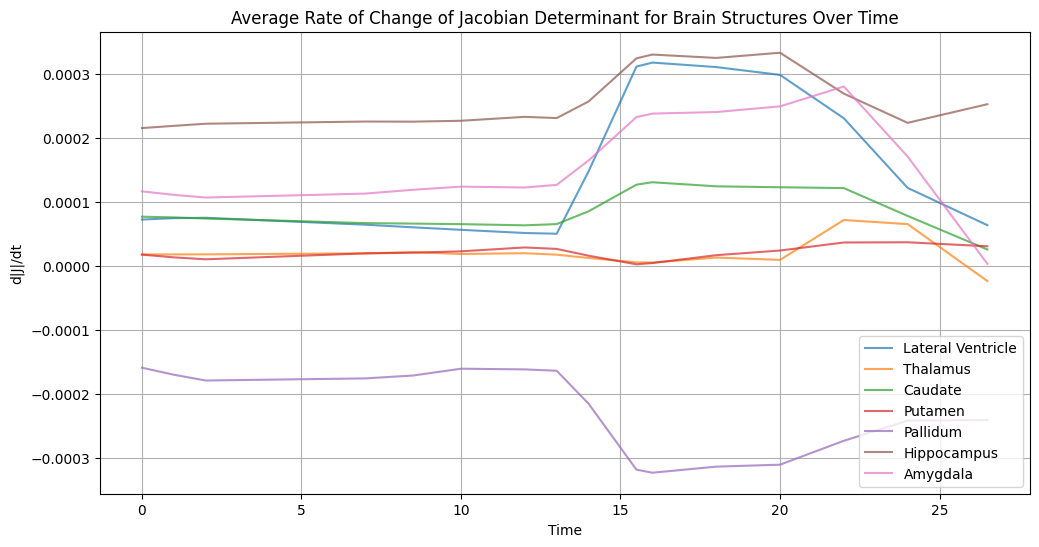

In [51]:
##Rate of Change of Jacobian Determinant for Brain Structures Over Time (d|J|/dt)
dj = torch.stack(stack_total_jac_det, axis=0)
dj_np = dj.cpu().numpy()
region_mask = I0_seg.cpu().numpy()

dj_derivative = torch.gradient(dj, spacing=(time.cpu().detach(),), dim=0)[0].cpu().numpy()
# dj_derivative = torch.zeros_like(dj)

# for t in range(len(time)):
#     grad_outputs = torch.zeros_like(dj)
#     grad_outputs[t] = 1  
#     voxelwise_derivative[t] = torch.autograd.grad(
#         dj,  
#         time, 
#         grad_outputs=grad_outputs,
#         retain_graph=True,  
#         create_graph=True 
#     )[0][t]
paired_structures = {
    "Lateral Ventricle": (4, 43),
    "Thalamus": (10, 49),
    "Caudate": (11, 50),
    "Putamen": (12, 51),
    "Pallidum": (13, 52),
    "Hippocampus": (17, 53),
    "Amygdala": (18, 54)
}

structure_derivatives = {structure: [] for structure in paired_structures.keys()}

for t in range(dj_derivative.shape[0]):
    for structure, (left_id, right_id) in paired_structures.items():
        left_mask = region_mask == left_id
        right_mask = region_mask == right_id
        
        left_values = dj_derivative[t][left_mask]
        right_values = dj_derivative[t][right_mask]
        
        combined_mean = np.mean(np.concatenate([left_values, right_values]))
        structure_derivatives[structure].append(combined_mean)

plt.figure(figsize=(12, 6))
for structure, avg_derivative in structure_derivatives.items():
    plt.plot(time.cpu().detach().numpy(), avg_derivative, label=structure, alpha=0.7)

plt.xlabel('Time')
plt.ylabel(r'd|J|/dt')
plt.title('Average Rate of Change of Jacobian Determinant for Brain Structures Over Time')
plt.legend()
plt.grid()
wandb.log({"Average_Rate_of_Change": wandb.Image(plt)})
plt.show()


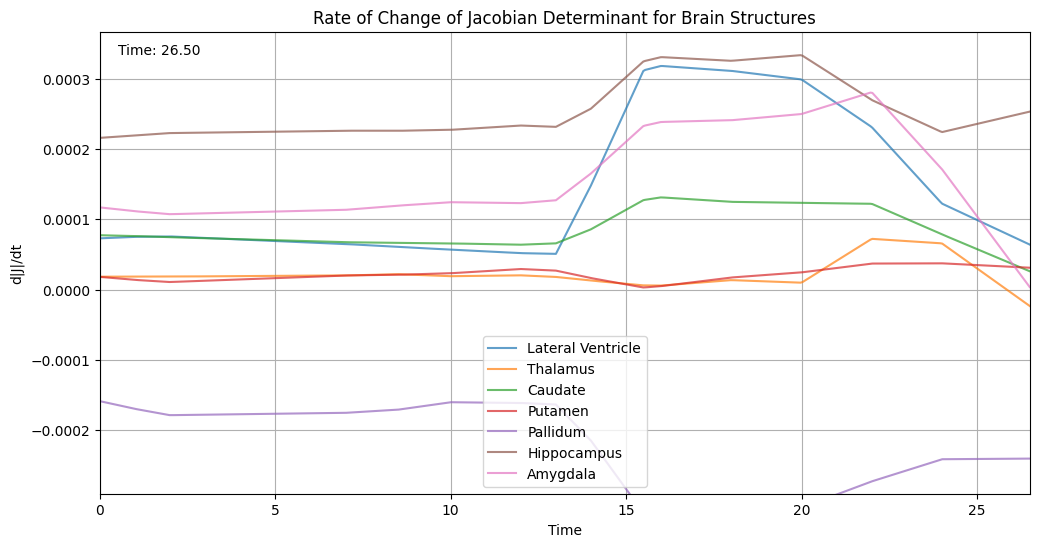

In [54]:

#interpolate structure derivatives for smooth animation
# time_np = time.cpu().numpy()
num_frames = len(time_np) * 30  #30 frames per second
interpolated_time = np.linspace(time_np[0], time_np[-1], num_frames)

# Interpolating derivative values over time
interpolated_structure_derivatives = {
    structure: np.interp(interpolated_time, time_np, derivatives)
    for structure, derivatives in structure_derivatives.items()
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(time_np[0], time_np[-1])
ax.set_ylim(
    min(min(values) for values in interpolated_structure_derivatives.values()) * 0.9,
    max(max(values) for values in interpolated_structure_derivatives.values()) * 1.1
)
ax.set_xlabel('Time')
ax.set_ylabel(r'd|J|/dt')
ax.set_title('Rate of Change of Jacobian Determinant for Brain Structures')
lines = {structure: ax.plot([], [], label=structure, alpha=0.7)[0] for structure in paired_structures.keys()}
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.legend()
ax.grid(True)

def update(frame):
    current_time = interpolated_time[frame]
    time_text.set_text(f'Time: {current_time:.2f}')
    for structure, line in lines.items():
        line.set_data(interpolated_time[:frame+1], interpolated_structure_derivatives[structure][:frame+1])
    return (*lines.values(), time_text)

ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1000 / 30)

# ani.save('rate_of_change_jacobian.mp4', writer='ffmpeg',  codec='vp9', fps=30, dpi=300)
ani.save('rate_of_change_jacobian.mp4', writer='ffmpeg',  codec='mpeg4', fps=30, dpi=300)

wandb.log({"Rate_of_Change_Animation": wandb.Video('rate_of_change_jacobian.mp4')})
plt.show()


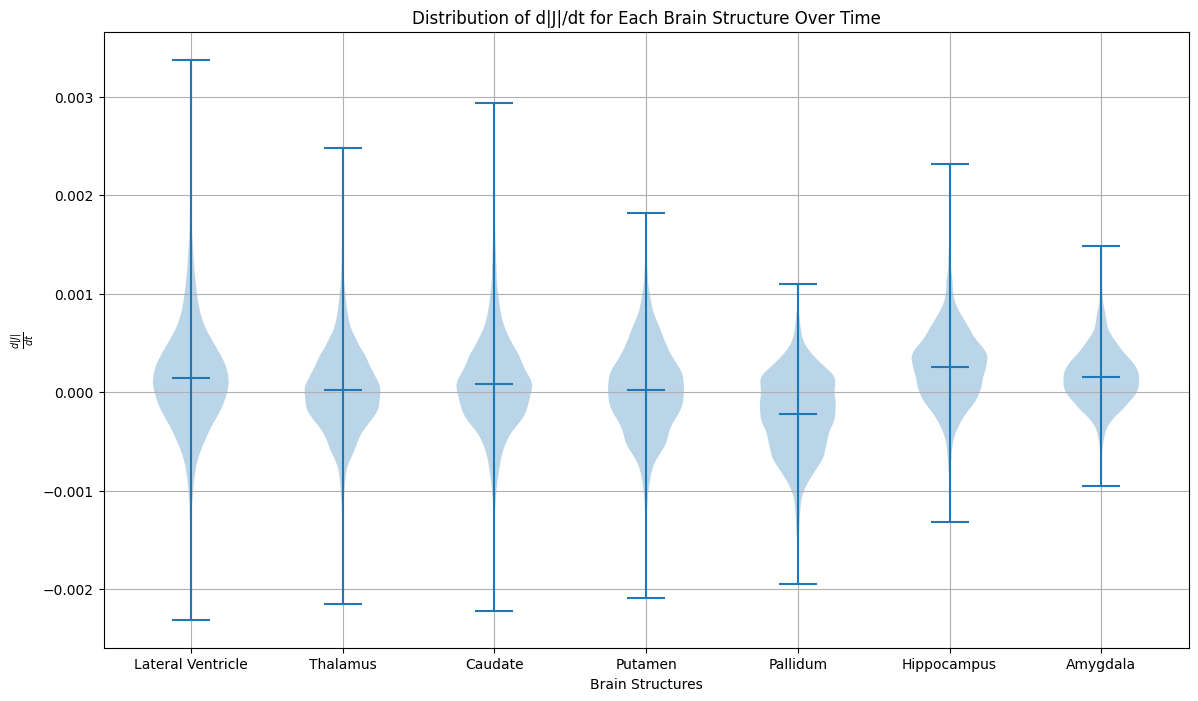

In [55]:

paired_structures = {
    "Lateral Ventricle": (4, 43),
    "Thalamus": (10, 49),
    "Caudate": (11, 50),
    "Putamen": (12, 51),
    "Pallidum": (13, 52),
    "Hippocampus": (17, 53),
    "Amygdala": (18, 54)
}

structure_derivatives = {structure: [] for structure in paired_structures.keys()}

for t in range(dj_derivative.shape[0]): 
    for structure, (left_id, right_id) in paired_structures.items():
        left_mask = region_mask == left_id
        right_mask = region_mask == right_id
        
        left_values = dj_derivative[t][left_mask]
        right_values = dj_derivative[t][right_mask]
        
        # left_values_np = left_values.cpu().numpy() 
        # right_values_np = right_values.cpu().numpy()
        left_values_np = left_values
        right_values_np = right_values
        
        structure_derivatives[structure].append(np.concatenate([left_values_np, right_values_np]))

violin_data = []

#flatten each structure's list of voxelwise derivatives across time
for structure in paired_structures.keys():
    flattened_values = np.concatenate(structure_derivatives[structure])
    violin_data.append(flattened_values)

fig, ax = plt.subplots(figsize=(14, 8))
ax.violinplot(violin_data, showmeans=True)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys())

ax.set_xlabel('Brain Structures')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Distribution of d|J|/dt for Each Brain Structure Over Time')

ax.grid(True)

plt.show()


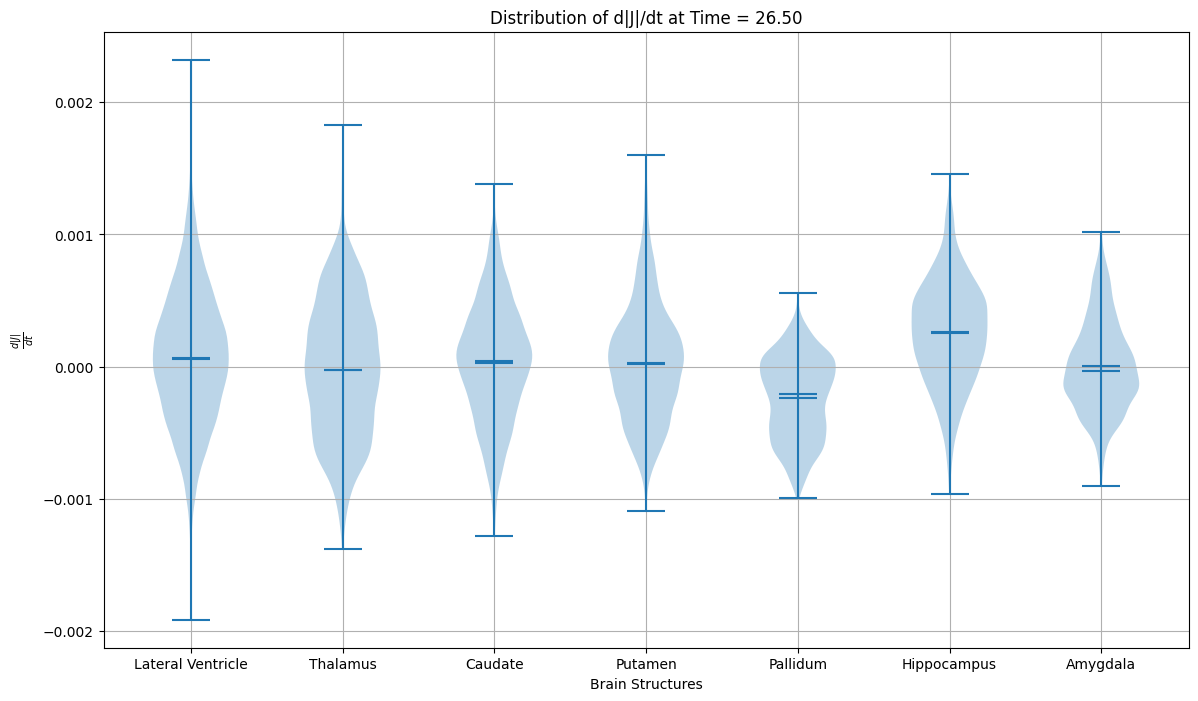

In [57]:
paired_structures = {
    "Lateral Ventricle": (4, 43),
    "Thalamus": (10, 49),
    "Caudate": (11, 50),
    "Putamen": (12, 51),
    "Pallidum": (13, 52),
    "Hippocampus": (17, 53),
    "Amygdala": (18, 54)
}

structure_derivatives = {structure: [] for structure in paired_structures.keys()}

for t in range(dj_derivative.shape[0]):  
    for structure, (left_id, right_id) in paired_structures.items():
        left_mask = region_mask == left_id
        right_mask = region_mask == right_id
        
        left_values = dj_derivative[t][left_mask]
        right_values = dj_derivative[t][right_mask]
        
        # left_values_np = left_values.cpu().numpy()  
        # right_values_np = right_values.cpu().numpy() 
        left_values_np = left_values
        right_values_np = right_values
        
        if left_values_np.size > 0 and right_values_np.size > 0:
            structure_derivatives[structure].append(np.concatenate([left_values_np, right_values_np]))
        else:
            structure_derivatives[structure].append([])

all_values = []
for structure in structure_derivatives.keys():
    for timepoint_data in structure_derivatives[structure]:
        all_values.extend(timepoint_data)

min_val = np.min(all_values)
max_val = np.max(all_values)

fig, ax = plt.subplots(figsize=(14, 8))

ax.set_xlabel('Brain Structures')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Distribution of d|J|/dt for Each Brain Structure Over Time')
ax.grid(True)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys())

# ax.set_ylim(min_val - 0.04, max_val + 0.04)
ax.set_ylim(0.005, 0.3)


violins = []

def update(frame):
    ax.clear()
    violin_data = []
    
    for structure in paired_structures.keys():
        data_for_timepoint = structure_derivatives[structure][frame]
        
        # if len(data_for_timepoint) > 0:#if list not empty
        violin_data.append(data_for_timepoint)
    
    # if len(violin_data) > 0:
    violins = ax.violinplot(violin_data, showmeans=True, showmedians=True)
    ax.set_xticks(np.arange(1, len(paired_structures) + 1))
    ax.set_xticklabels(paired_structures.keys())
    ax.set_xlabel('Brain Structures')
    ax.set_ylabel(r'$\frac{d|J|}{dt}$')
    ax.set_title(f'Distribution of d|J|/dt at Time = {time[frame]:.2f}')
    ax.grid(True)
    
    return violins

num_frames = len(time)
ani = FuncAnimation(fig, update, frames=num_frames, interval=1000/30, repeat=False)
# ani.save('dJ_dt_distribution_animation.mp4', writer='ffmpeg', codec='vp9', fps=5, dpi=300)
ani.save('dJ_dt_distribution_animation.mp4', writer='ffmpeg', codec='mpeg4', fps=5, dpi=300)

wandb.log({"Voxel |J| Animation": wandb.Video('dJ_dt_distribution_animation.mp4')})

plt.show()


### Voxelwise d|J|/dt

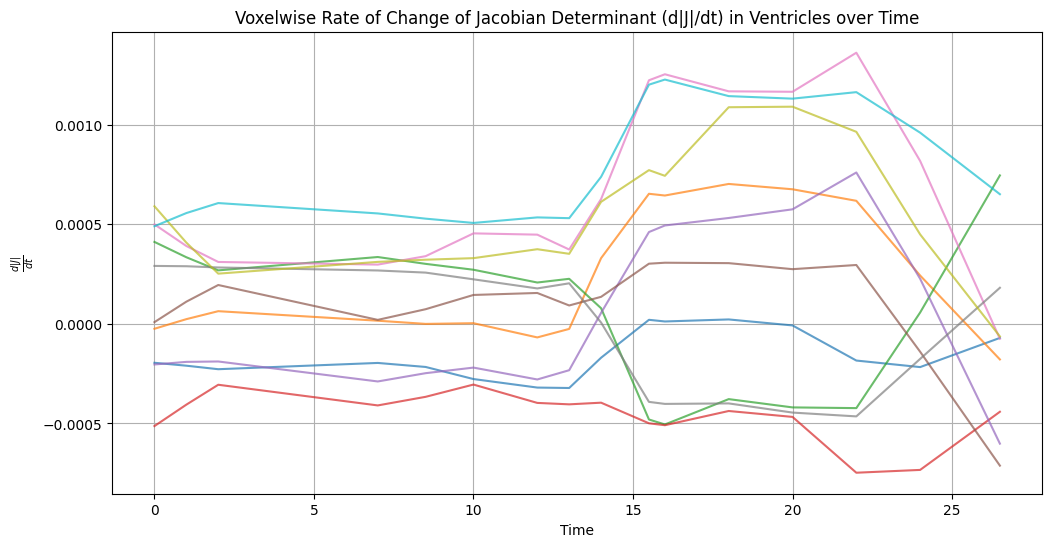

In [76]:
# dj = torch.stack(stack_total_jac_det, axis=0).to(device)
dj = torch.stack(stack_total_jac_det, axis=0)

dj_derivative = torch.gradient(dj, spacing=(time.cpu(),), dim=0)[0]  
# dj_derivative_np = dj_derivative.cpu().numpy()
dj_derivative_np = dj_derivative


#mask to identify ventricle voxels
I0_seg_np = I0_seg.cpu().numpy()
ventricle_indices = np.argwhere((I0_seg_np == 4) | (I0_seg_np == 43)) #69680

num_voxels_to_plot = 10
sampled_indices = ventricle_indices[np.random.choice(len(ventricle_indices), size=num_voxels_to_plot, replace=False)]

plt.figure(figsize=(12, 6))

for voxel_idx in sampled_indices:
    x, y, z = voxel_idx
    plt.plot(
        # time.cpu().numpy(), 
        time.cpu().detach().numpy(), 

        dj_derivative_np[:, x, y, z].cpu().detach().numpy(),
        # alpha=0.5, marker="*", label=f"Voxel ({x}, {y}, {z})"
        alpha=0.7,  label=f"Voxel ({x}, {y}, {z})"

    )

plt.xlabel('Time')
plt.ylabel(r'$\frac{d|J|}{dt}$')
plt.title('Voxelwise Rate of Change of Jacobian Determinant (d|J|/dt) in Ventricles over Time')
plt.grid(True)
wandb.log({"Voxelwise Rate of Change of Jacobian Determinant in Ventricles (d|J|/dt) over Time": wandb.Image(plt)})
plt.show()


/tmp/ipykernel_3483282/3104069536.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


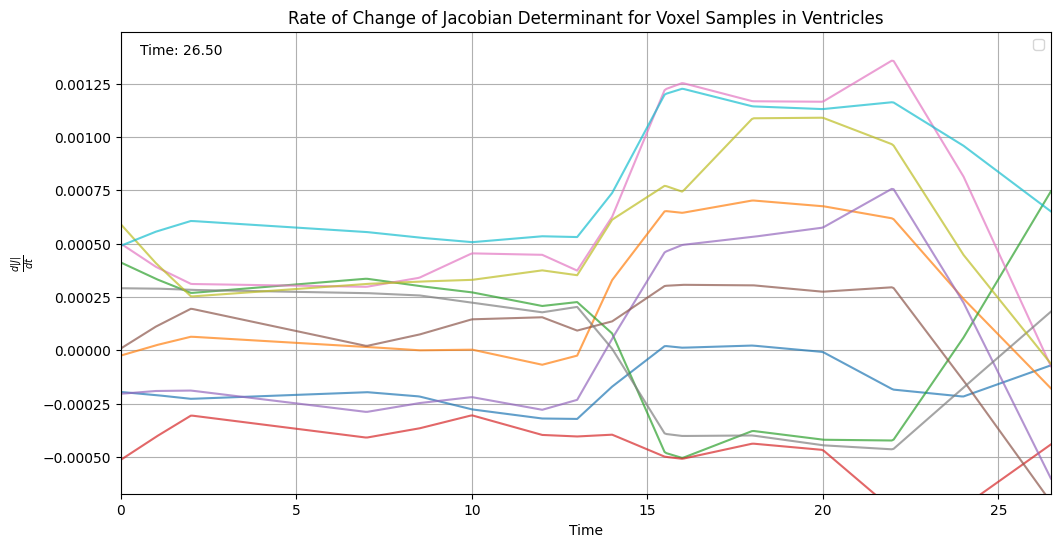

In [78]:
#animation

#interpolating time for smoother animation
# time_np = time.cpu().numpy()
time_np = time.cpu().detach().numpy()

num_frames = len(time_np) * 30  #30 frames per second
interpolated_time = np.linspace(time_np[0], time_np[-1], num_frames)

interpolated_voxel_derivatives = {
    i: np.interp(interpolated_time, time_np, dj_derivative_np[:, x, y, z].cpu().detach().numpy())
    for i, (x, y, z) in enumerate(sampled_indices)
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(time_np[0], time_np[-1])
ax.set_ylim(
    min(min(values) for values in interpolated_voxel_derivatives.values()) * 0.9,
    max(max(values) for values in interpolated_voxel_derivatives.values()) * 1.1
)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Rate of Change of Jacobian Determinant for Voxel Samples in Ventricles')
lines = {i: ax.plot([], [], alpha=0.7)[0] for i in interpolated_voxel_derivatives.keys()}
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.legend()
ax.grid(True)

def update(frame):
    current_time = interpolated_time[frame]
    time_text.set_text(f'Time: {current_time:.2f}')
    for i, line in lines.items():
        line.set_data(interpolated_time[:frame+1], interpolated_voxel_derivatives[i][:frame+1])
    return (*lines.values(), time_text)

ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1000 / 30)

# ani.save('rate_of_change_jacobian_voxels.mp4', writer='ffmpeg', codec='vp9', fps=30, dpi=300)
ani.save('rate_of_change_jacobian_voxels.mp4', writer='ffmpeg', codec='mpeg4', fps=30, dpi=300)
wandb.log({"Rate_of_Change_Animation_Voxels": wandb.Video('rate_of_change_jacobian_voxels.mp4')})

plt.show()


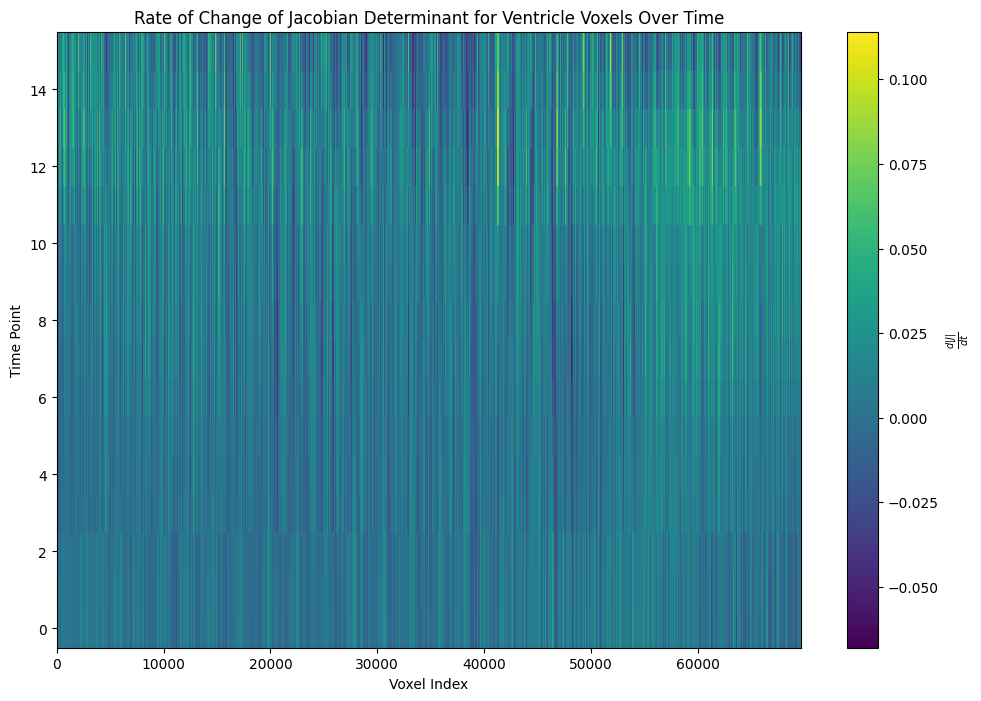

In [23]:
#HEATMAP
dj_derivative_np = dj_derivative.cpu().numpy()
I0_seg_np = I0_seg.cpu().numpy()

ventricle_indices = np.argwhere((I0_seg_np == 4) | (I0_seg_np == 43))

num_timepoints, height, width, depth = dj_derivative_np.shape
ventricle_dj = np.zeros((num_timepoints, len(ventricle_indices)))

for t_idx in range(num_timepoints):
    for i, (x, y, z) in enumerate(ventricle_indices):
        ventricle_dj[t_idx, i] = dj_derivative_np[t_idx, x, y, z]

plt.figure(figsize=(12, 8))
plt.imshow(ventricle_dj, aspect='auto', cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label=r'$\frac{d|J|}{dt}$')
plt.xlabel('Voxel Index')
plt.ylabel('Time Point')
plt.title('Rate of Change of Jacobian Determinant for Ventricle Voxels Over Time')
plt.grid(False)
plt.show()


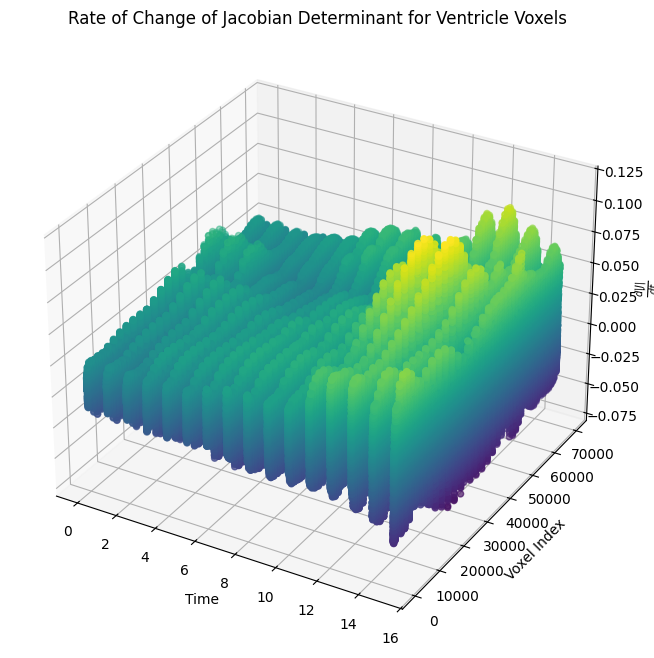

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

time_points = np.repeat(np.arange(num_timepoints), len(ventricle_indices))
voxel_indices_flat = np.tile(np.arange(len(ventricle_indices)), num_timepoints)

#flatten the d|J|/dt values
dj_derivative_flat = ventricle_dj.flatten()

#plot surface
ax.scatter(time_points, voxel_indices_flat, dj_derivative_flat, c=dj_derivative_flat, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Voxel Index')
ax.set_zlabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Rate of Change of Jacobian Determinant for Ventricle Voxels')

plt.show()


/tmp/ipykernel_1992456/2042003892.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(timepoint_data, labels=[f"{t:.2f}" for t in time.cpu().numpy()])


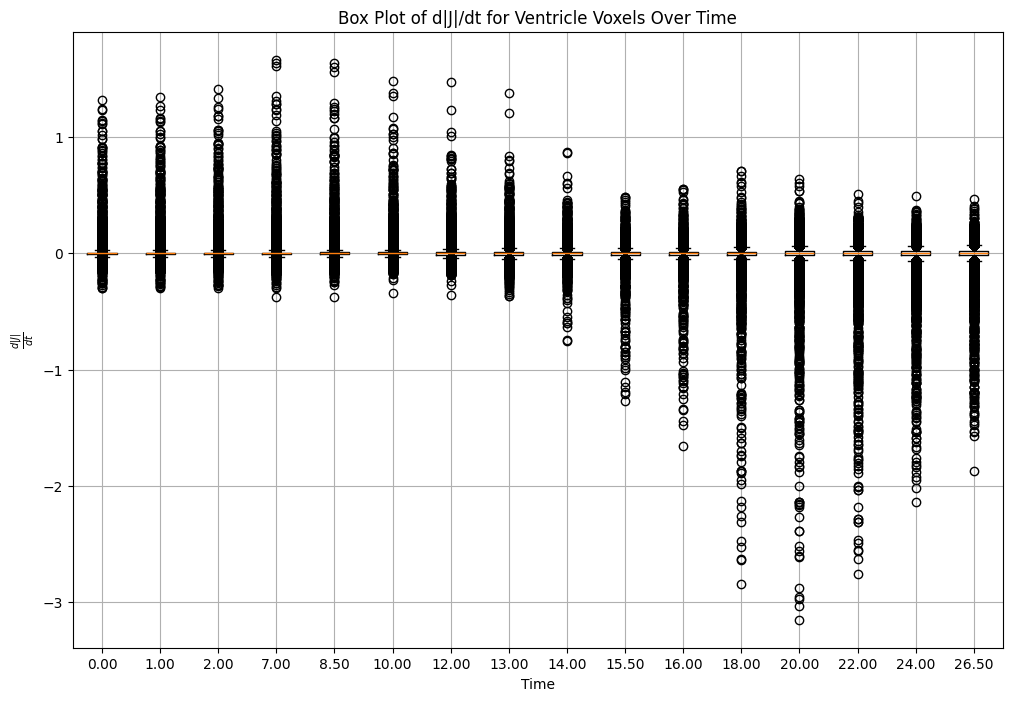

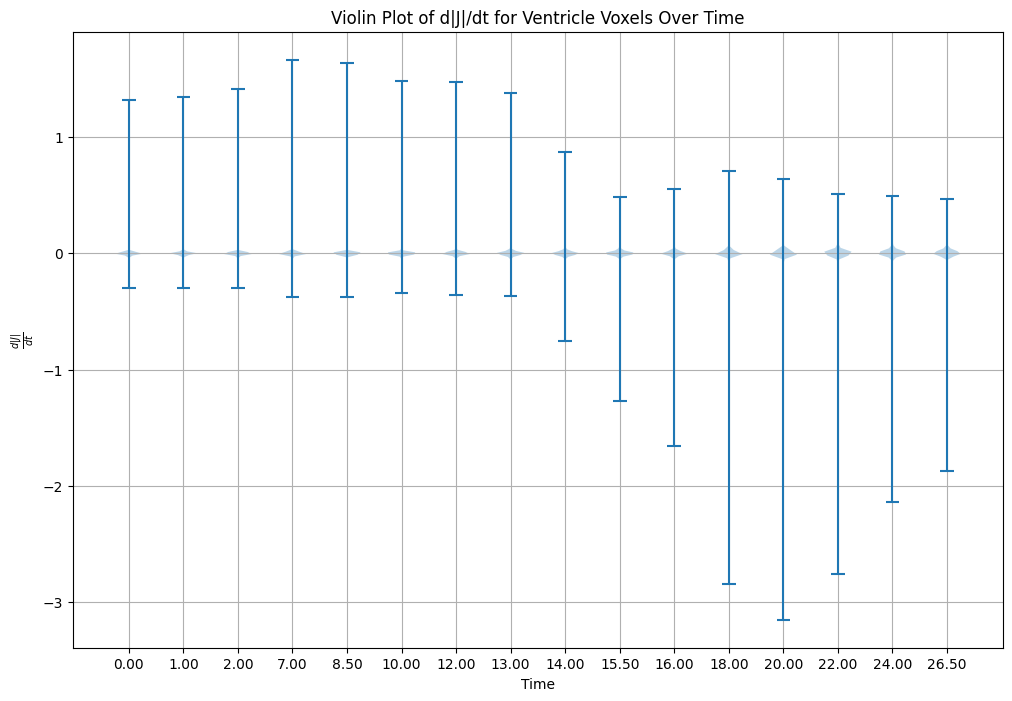

In [32]:
dj_derivative_flat = dj_derivative_np.reshape(dj_derivative_np.shape[0], -1)  #shape: (num_timepoints, num_voxels)

timepoint_data = []

#get d|J|/dt values for ventricle voxels at each time point
for t_idx in range(dj_derivative_flat.shape[0]):
    ventricle_values = dj_derivative_flat[t_idx, ventricle_indices[:, 0] * height * width + ventricle_indices[:, 1] * width + ventricle_indices[:, 2]]
    timepoint_data.append(ventricle_values)

plt.figure(figsize=(12, 8))
plt.boxplot(timepoint_data, labels=[f"{t:.2f}" for t in time.cpu().numpy()])

plt.xlabel('Time')
plt.ylabel(r'$\frac{d|J|}{dt}$')
plt.title('Box Plot of d|J|/dt for Ventricle Voxels Over Time')
plt.grid(True)
plt.show()


fig, ax = plt.subplots(figsize=(12, 8))

ax.violinplot(timepoint_data)

ax.set_xlabel('Time')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Violin Plot of d|J|/dt for Ventricle Voxels Over Time')

ax.set_xticks(range(1, len(timepoint_data) + 1))
ax.set_xticklabels([f"{t:.2f}" for t in time.cpu().numpy()])

ax.grid(True)
plt.show()


#### GENERATING JACOBIAN MAP VIDEO

/tmp/ipykernel_3483282/3652124893.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


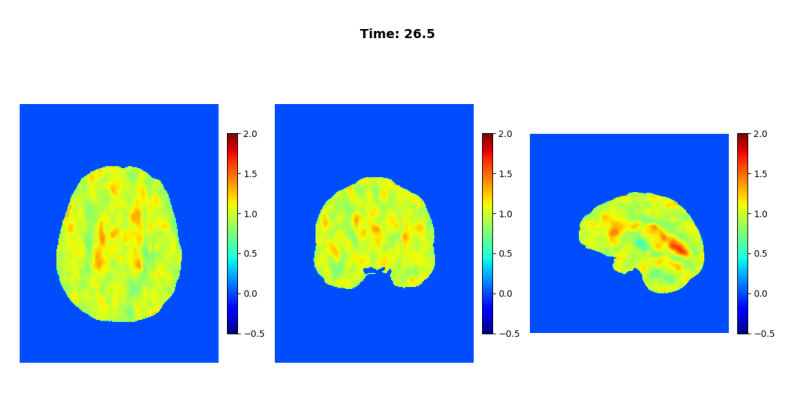

In [79]:

fig, ax = plt.subplots(figsize=(10, 7))

#initialise function to display the first frame
def init():
    ax.clear()  #clear the axis
    ax.axis('off') 
    return []

#update function for each frame
def update(frame):
    ax.clear()  #clear previous frame
    ax.axis('off')

    #render the figure to a canvas
    canvas = FigureCanvas(video_jacobian_maps[frame])
    canvas.draw()
    
    #convert canvas to a numpy array
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(canvas.get_width_height()[::-1] + (3,))  #reshape to (height, width, 3)

    ax.imshow(img)
    return []

ani = FuncAnimation(fig, update, frames=len(video_jacobian_maps), init_func=init, blit=True, interval=1000)

video_filename = 'jacobian_maps.mp4'
# ani.save(video_filename, writer='ffmpeg', fps=3,  codec='vp9', dpi=300)  #3 frame per second
ani.save(video_filename, writer='ffmpeg', fps=3,  codec='mpeg4', dpi=300)  #3 frame per second

wandb.log({"Jacobian Maps Video": wandb.Video(video_filename, format="mp4")})

plt.show()
plt.close(fig)
# plt.fig(video_jacobian_maps[0])

/tmp/ipykernel_3483282/4020466116.py:23: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


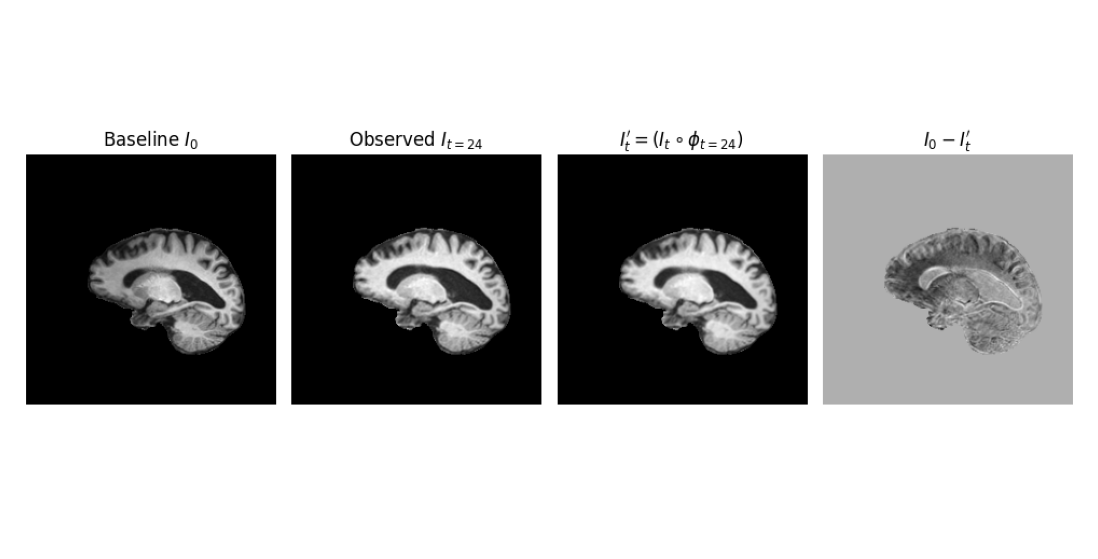

In [80]:
#number of time points and images per time point
num_time_points = len(video_images)
num_images = len(video_images[0])

#initialize a list to hold the composite images
composite_images = []

#create individual figures for each time point and store them
for t in range(num_time_points):
    fig, axs = plt.subplots(1, num_images, figsize=(10, 5))

    for i in range(num_images):
        axs[i].imshow(video_images[t][i], cmap='gray')
        axs[i].set_title(video_titles[t][i])
        axs[i].axis('off')

    plt.tight_layout()

    #render the figure to a canvas and convert to a numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()
    
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(canvas.get_width_height()[::-1] + (3,))  # (height, width, 3)
    
    composite_images.append(img)
    plt.close(fig) 

fig, ax = plt.subplots(figsize=(15, 7))

def init():
    ax.clear()
    ax.axis('off')
    return []

def update(frame):
    ax.clear()
    ax.axis('off')
    ax.imshow(composite_images[frame])
    return []

ani = FuncAnimation(fig, update, frames=len(composite_images), init_func=init, blit=True, interval=1000)

video_filename = 'residual.mp4'
ani.save(video_filename, writer='ffmpeg', fps=1, dpi=300, codec='vp9')
# ani.save(video_filename, writer='ffmpeg', fps=1, dpi=300, codec='mpeg4')

# wandb.log({"Time Lapse Transition Video": wandb.Video(video_filename, format="mp4")})
plt.show()
plt.close(fig)


/tmp/ipykernel_3483282/1586060285.py:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


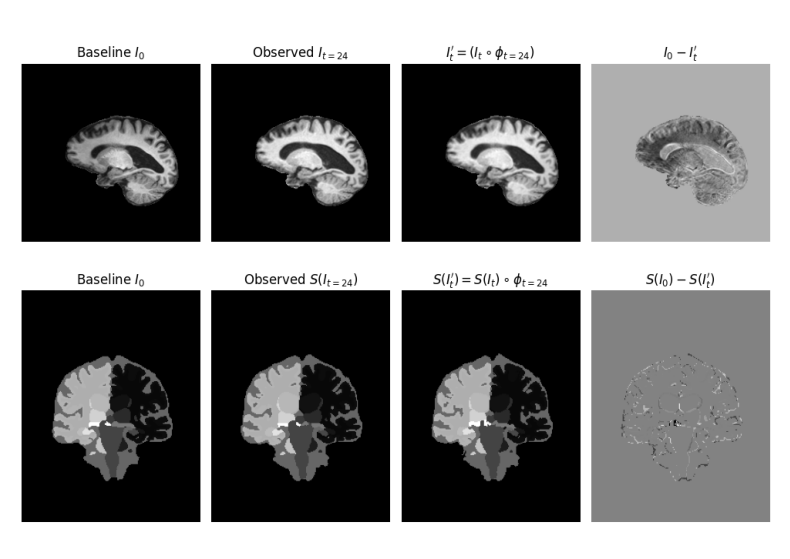

In [82]:

#number of time points and images per time point
num_time_points = len(video_images)
num_images = len(video_images[0])

#initialize a list to hold the composite images
composite_images = []

#create individual figures for each time point and store them
for t in range(num_time_points):
    fig, axs = plt.subplots(2, num_images, figsize=(10, 7))
    
    for i in range(num_images):
        axs[0, i].imshow(video_images[t][i], cmap='gray')
        axs[0, i].set_title(video_titles[t][i])
        axs[0, i].axis('off')
    
    for i in range(num_images):
        axs[1, i].imshow(video_images_seg[t][i], cmap='gray')
        axs[1, i].set_title(video_titles_seg[t][i])
        axs[1, i].axis('off')

    plt.tight_layout()
    
    #render the figure to a canvas and convert to a numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()
    
    #convert the canvas to a numpy array
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(canvas.get_width_height()[::-1] + (3,))  #(height, width, 3)
    
    # Append the image to the list
    composite_images.append(img)
    plt.close(fig) 

#create the animation using the stored images
fig, ax = plt.subplots(figsize=(15, 7))

def init():
    ax.clear()
    ax.axis('off')
    return []

def update(frame):
    ax.clear()
    ax.axis('off')
    ax.imshow(composite_images[frame])
    return []

ani = FuncAnimation(fig, update, frames=len(composite_images), init_func=init, blit=True, interval=1000)

video_filename = 'time_lapse_transition.mp4'
# ani.save(video_filename, writer='ffmpeg', fps=1, dpi=300, codec='vp9')
ani.save(video_filename, writer='ffmpeg', fps=1, dpi=300, codec='mpeg4')

wandb.log({"Time Lapse Transition Video": wandb.Video(video_filename, format="mp4")})
plt.show()
plt.close(fig)